## 1. Patient selection

In [1]:
import pandas as pd
df_rzw = pd.read_csv('../extractions/20240205_Clustering/ZWN_clustering_variables.csv', sep=',')
print('patients with RA-ICD code\t\t\t: %s ' % (len(df_rzw)))
df_rzw = df_rzw[~df_rzw['FirstDMARD_date'].isna()]
print('patients with DMARD prescribed\t\t\t: %s ' % (len(df_rzw)))
df_rzw = df_rzw[df_rzw['FollowUp'] > 90]
print('patients with Follow up of at least 3 months \t: %s ' % (len(df_rzw)))

patients with RA-ICD code			: 304 
patients with DMARD prescribed			: 304 
patients with Follow up of at least 3 months 	: 304 


### 1.1. Fill in missingness of seropositivity (with Rachel's annotation)
Add annotated seropositivty to fill in the missingness
- Patients with missing seropositive information were annotated by a physician

In [2]:
import pandas as pd
import numpy as np

df_extra_sero = pd.read_csv(r'../data/ZWN_annotated_serostatus_14mo.csv', sep=';')    
d_extra_rf = dict(zip(df_extra_sero['Identifier'], df_extra_sero['RF_yes_no']))
d_extra_acpa = dict(zip(df_extra_sero['Identifier'], df_extra_sero['ACPA_yes_no']))

df_rzw['ACPA'] = df_rzw['ACPA'].fillna(df_rzw['Identifier'].apply(lambda x : d_extra_acpa[x] if x in d_extra_acpa.keys() else np.nan))
df_rzw['RF'] = df_rzw['RF'].fillna(df_rzw['Identifier'].apply(lambda x : d_extra_rf[x] if x in d_extra_rf.keys() else np.nan))

### 1.2 Check missingness

<AxesSubplot: >

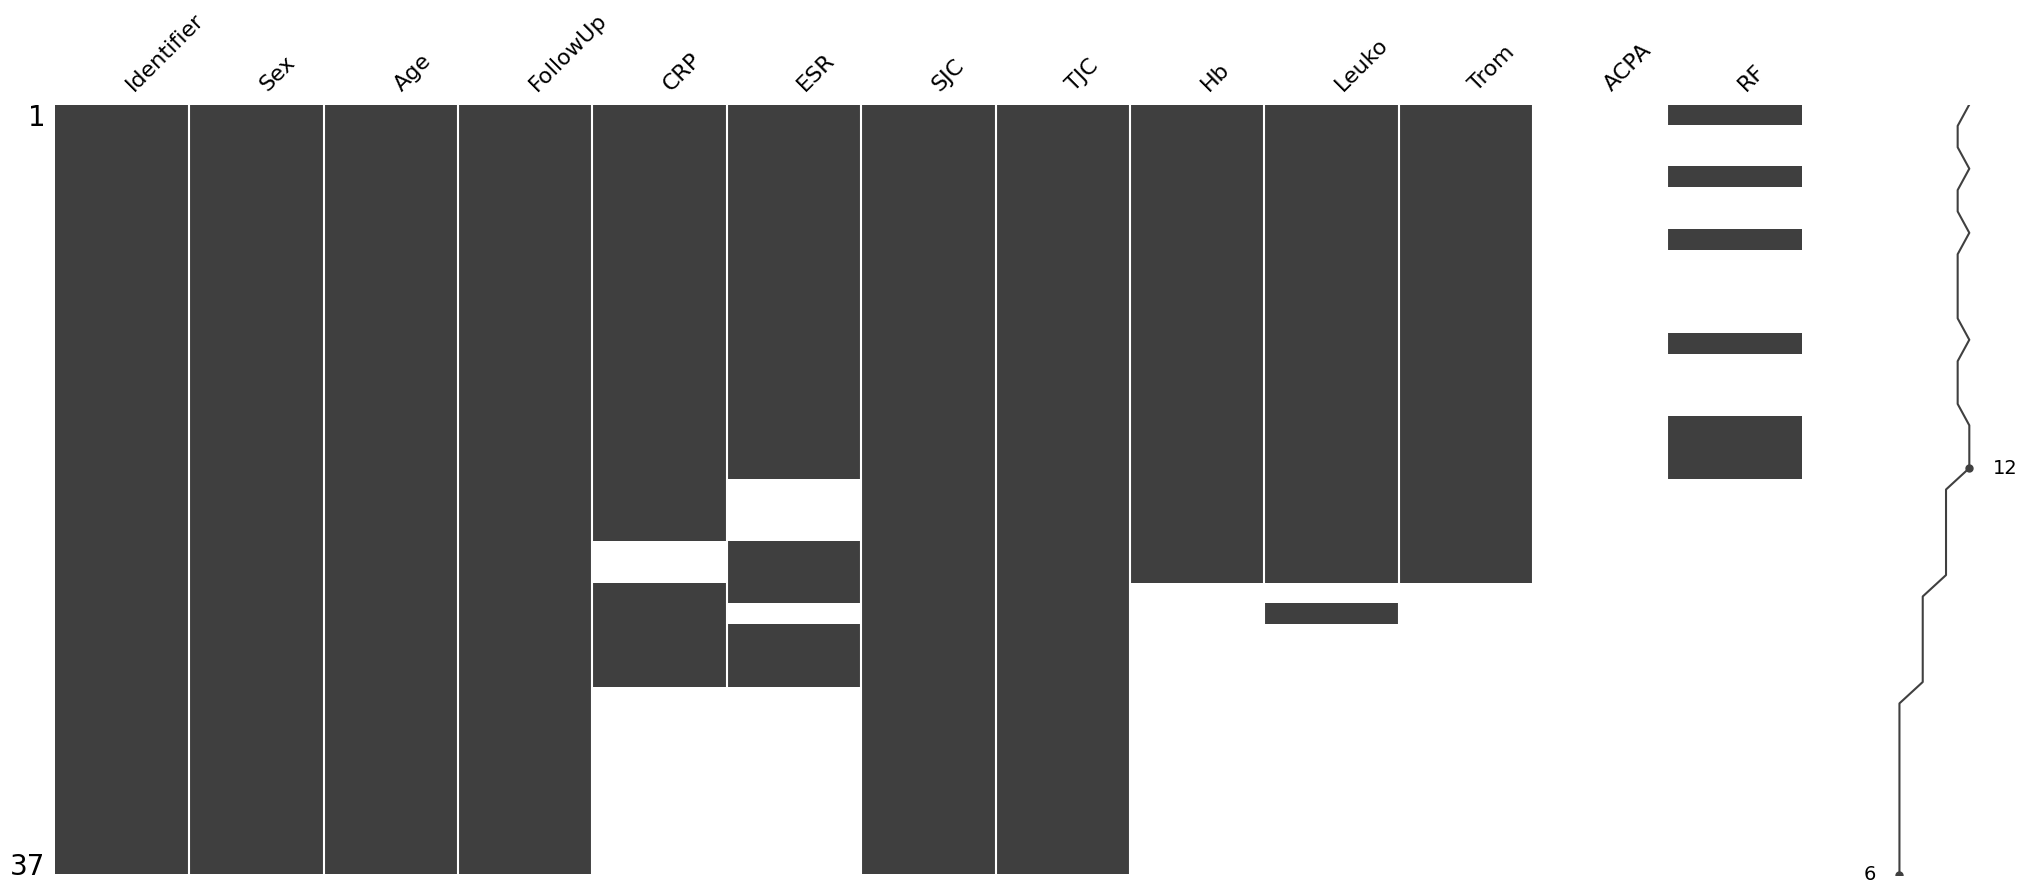

In [4]:
import missingno as msno
    
%matplotlib inline

l_essential =['Identifier', 'Sex', 'Age',  'FollowUp', 'CRP', 'ESR', 'SJC', 'TJC', 'Hb','Leuko', 'Trom', 'ACPA', 'RF']# ['Identifier', 'Sex', 'Age',  'FollowUp', 'ACPA', 'RF', 'CRP', 'ESR', 'SJC', 'TJC', 'Hb', 'Ht','MCV',  'MCHC', 'MCH', 'Leuko', 'Trom']
#l_essential = ['Identifier', 'Sex', 'Age',  'FollowUp', 'ACPA', 'RF', 'CRP', 'ESR', 'SJC', 'TJC', 'Hb', 'Ht','MCV',  'MCHC', 'MCH', 'Leuko', 'Trom']

l_essential_woSero =  ['Identifier', 'Sex', 'Age',  'FollowUp', 'CRP', 'ESR', 'SJC', 'TJC', 'Hb','Leuko', 'Trom']


df_rzw['Missingness'] = df_rzw[l_essential_woSero].isna().sum(axis=1)

msno.matrix(df_rzw[df_rzw['ACPA'].isna()].sort_values(by='Missingness')[l_essential]) 

In [ ]:


len(df_rzw.dropna(subset=l_essential_woSero)[l_essential] )

In [ ]:
df_rzw[l_essential].isnull().sum()/len(df_rzw)*100

### Annotate patients that are missing DAS or seropositivity

In [ ]:
l_essential = ['Identifier', 'Sex', 'Age',  'FollowUp', 'CRP', 'ESR', 'SJC', 'TJC', 'Hb','Leuko', 'Trom'] # 

df_final = df_rzw.dropna(subset=l_essential) 

l_pat_missing_DAS = list(df_final['Identifier'].unique())
l_pat_missing_Sero = list(df_final[((df_final['ACPA'].isna()) | (df_final['RF'].isna()))]['Identifier'].unique())

print('Patients with missing DAS follow up information:', len(l_pat_missing_DAS))
print('Patients with missing Sero:', len(l_pat_missing_Sero))

In [ ]:
import pandas as pd
### Initialize functions
import importlib as imp
import Functions as func
imp.reload(func)

X_column='Waarde'
id_column='Identifier'
date_column = 'Invoerdatum'

df_conc =pd.read_csv('../data/ZWN_conclusie.csv', sep=';')
df_conc_sero = df_conc[df_conc['Identifier'].isin(l_pat_missing_Sero)].copy()
print('Conclusions of patients without seropositivity status: ', len(df_conc_sero[id_column].unique()))

# Merge entries of same patient together

# Fill na with empty string (to prevent errors in downstream functions)
df_conc_sero['Waarde'] = df_conc_sero['Waarde'].fillna('')

# Sort on date
df_conc_sero = df_conc_sero.sort_values(by=date_column)

# Merge all conclusion entries together per patient
def entriesPatientMerge(pat_df, id_column, X_column, date_column):
    field = ''
    for i, txt in enumerate(pat_df[X_column]):
        field += " [Date %s] " % (pat_df.iloc[i][date_column][:10]) + txt + " "
    return {X_column: field, id_column : pat_df[id_column].iloc[0]}

df_combined = pd.DataFrame(columns=[X_column,  id_column])
#print(df_conc[id_column].unique())

for pat in df_conc_sero[id_column].unique():
    pat_df = df_conc_sero[df_conc_sero[id_column]==pat].copy()
    pat_df = pat_df.reset_index(drop=True)
    df_combined = df_combined.append(entriesPatientMerge(pat_df, id_column, X_column, date_column), ignore_index=True)

# Remove accents 
df_combined['Waarde'] = df_combined['Waarde'].apply(lambda x : func.removeAccent(x))

    
# Export conclusions of pt with missing serostatus 
df_combined['RF_yes_no'] = ''
df_combined['ACPA_yes_no'] = ''
df_combined[['Identifier', 'RF_yes_no', 'ACPA_yes_no', 'Waarde']].to_csv(r'../proc/20240213_ZWN_missingSerostatus_14mo.csv', sep=';', index=False)    
df_combined.head()

In [ ]:
import pandas as pd
### Initialize functions
import importlib as imp
import Functions as func
imp.reload(func)

X_column='Waarde'
id_column='Identifier'
date_column = 'Invoerdatum'

df_conc =pd.read_csv('../data/ZWN_conclusie.csv', sep=';')
df_conc_das = df_conc[df_conc['Identifier'].isin(l_pat_missing_DAS)].copy()
df_conc_das['Remission_yes_no'] = ''

df_conc_das.to_csv(r'../proc/20240213_ZWN_Conclusions_remission_14mo.csv', sep=';', index=False)    

### 1.2 Select patients with complete information 
- we drop MCV, Ht, MCHC and MCH as they feature more than 40% missingness (while preferring to include ACPA & RF)

In [ ]:
l_essential = ['Identifier', 'Sex', 'Age',  'FollowUp', 'ACPA', 'RF', 'CRP', 'ESR', 'SJC', 'TJC', 'Hb','Leuko', 'Trom'] # 

df_final = df_rzw.dropna(subset=l_essential)
df_final = df_final.reset_index(drop=True)

df_final = df_final.rename(columns={'ACPA': 'aCCP', 'Identifier' : 'PATNR', 'ESR': 'BSE'})

# Export final selection
df_final.to_csv('../extractions/20240205_Clustering/patient_selection_rzwn.csv', sep='|', index=False)


## 2 Process mannequin information

### 2.1 import raw data

In [ ]:
df_rzw
#df_final = pd.read_csv('../extractions/20240205_Clustering/patient_selection_rzwn.csv', sep='|')

#df_final

### 2.2 Encode field for both swollen and tender differently

In [ ]:
l_cols_st = [col for col in df_final.columns if 'ST' in col]
for col in l_cols_st: 
    # Assign 1 if joint is reported to be both swollen and tender at same time
    col_sjc = col.replace('ST_', 'S_')
    col_tjc = col.replace('ST_', 'T_')
    if col_sjc in df_final.columns: 
        df_final[col_sjc] = df_final.apply(lambda x : 1 if x[col] == 1 else x[col_sjc], axis =1 )
    else : 
        df_final[col_sjc] = df_final.apply(lambda x : x[col], axis =1 )
    df_final[col_tjc] = df_final.apply(lambda x : 1 if x[col] == 1 else x[col_tjc], axis =1 )

### 2.3 Encode joints according to same format as Leiden data

In [ ]:
import re 

def convert_EAC_name_Mannequin(col_name):
    """
    Standardize the data by converting the name of a METEOR variable to the HIX equivalent
    
    Input:
        col_name = initial column name
    Return: 
        new_col = updated column name
    """
    new_col = ""
    d_swollen = {'S' : 'Zwelling_', 'T': 'Pijn_'}
    d_side = {'Links': 'links', 'Rechts' : 'rechts'} # 
    d_side_alt = {'Links': 'L', 'Rechts': 'R'}
    # 'MTAR' : 'tarsometatarsaal', 
    d_entity = {'acromioclavicular': 'acromioclaviaculair', 'ankle': 'bovenste spronggewricht', 'talonavicular': 'onderste spronggewricht', 'elbow' : 'Elleboog', 'ip' : 'IP', 'footip' : 'VIP', 'footpip' : 'VPIP', 'knee' : 'knie', 'mcp' : 'mcp', 'mtp' : 'mtp', 'pip' : 'pip', 'sternoclavicular' : 'sternoclaviculair', 'glenohumeral' : 'schouder', 'TMJ' : 'temporomandibulair', 'wrist' : 'pols','pip' : 'pip', 'dip' : 'dip', 
                'hip' : 'heup'} # Or is it PIP
    
    type_ = col_name.split('_')[0]
    joint_ = col_name.split('_')[1]
    side_ = col_name.split('_')[-1]
    
    # Extract numeral from joint
    
    
    #print(type_, joint_, side_)
    if type_ in d_swollen and side_ in d_side:
        # extract specific joint
        joint = re.search("^(" + "|".join(d_entity.keys())+ ")$", ''.join([i for i in joint_ if not i.isdigit()]))
        numeral_ = "".join([i for i in joint_ if i.isdigit()])
        # Can we extract a number? 
        #if numeral_ != "":
        #    numeral_ = int(numeral_)
        #    print(numeral_)
        if joint and '28' not in col_name:
            new_col += d_swollen[type_]
            
            # Account for exceptions
            if joint[0] == 'elbow' and side_=='Rechts' :
                entity = d_entity[joint[0]].lower()
            elif  joint[0] == 'ankle' and side_=='Links':
                entity = 'bovenste spronggewicht' 
            elif joint[0] == 'footpip' : 
                entity = 'pip'
            elif joint[0] == 'footip' : 
                entity = 'IP voet'
            else : 
                entity = d_entity[joint[0]]
            
            new_col += entity
            
              
            if numeral_.isdigit() and entity != 'IP voet' and entity != 'IP': 
                new_col += " " + numeral_ # note specific joint
            if joint[0] in ['elbow', 'glenohumeral', 'wrist', 'sternoclavicular', 'acromioclavicular','TMJ']: # 'MTAR', 
                new_col += " " + d_side_alt[side_]  
            elif joint[0] in ['pip'] :
                new_col += " " + d_side[side_] + " hand"
            elif joint[0] in ['footip'] :
                new_col += " " + d_side[side_]
            elif joint[0] in ['footpip'] :
                new_col += " " + d_side[side_] + " voet"
            
                
            else :
                new_col += " " + d_side[side_]
        #print(new_col)
        return new_col, True, '_'.join(new_col.split('_')[1:])
    else : 
        return col_name, False, col_name

df_man = df_final.copy()
# is vip pip
# DAS joints are : enkel (spronggewricht / spronggewicht), Elleboog/elleboog, heup, ip, knie,  mcp, mtp, pip,  schouder,  pols,  
l_das_joints = ['acromioclavicular', 'ankle','talonavicular', 'elbow', 'ip', 'knee', 'mcp',  'mtp', 'pip', 'sternoclavicular', 'glenohumeral',  'TMJ', 'wrist', 'footip', 'footpip',  'dip', 'hip']         # 'MTAR',      
d_joint = {}
d_simple_joint = {} # without side for followup

for joint in l_das_joints:
    for col in df_man.columns :
        if joint in col and convert_EAC_name_Mannequin(col)[1]:
            d_joint[col] = convert_EAC_name_Mannequin(col)[0]
            d_simple_joint['_'.join(col.split('_')[1:])] = convert_EAC_name_Mannequin(col)[2]

# Translate 
l_joints = list(d_joint.values())

df_man = df_man.rename(columns = d_joint)

df_man

In [ ]:
    l_DAS28 = ['Pijn_pols L', 'Pijn_pols R', 'Pijn_pip 2 links hand', 'Pijn_pip 2 rechts hand', 'Pijn_pip 3 links hand', 'Pijn_pip 3 rechts hand',
 'Pijn_pip 4 links hand', 'Pijn_pip 4 rechts hand', 'Pijn_pip 5 links hand', 'Pijn_pip 5 rechts hand', 
 'Pijn_mcp 1 links', 'Pijn_mcp 1 rechts', 'Pijn_mcp 2 links', 'Pijn_mcp 2 rechts', 'Pijn_mcp 3 links', 'Pijn_mcp 3 rechts',
 'Pijn_mcp 4 links', 'Pijn_mcp 4 rechts', 'Pijn_mcp 5 links', 'Pijn_mcp 5 rechts', 'Pijn_schouder L', 'Pijn_schouder R', 'Pijn_Elleboog L','Pijn_elleboog R',
 'Pijn_knie links', 'Pijn_knie rechts', 
           
 'Zwelling_pols L', 'Zwelling_pols R', 'Zwelling_pip 2 links hand',  'Zwelling_pip 2 rechts hand',
 'Zwelling_pip 3 links hand',  'Zwelling_pip 3 rechts hand', 'Zwelling_pip 4 links hand', 'Zwelling_pip 4 rechts hand',  'Zwelling_pip 5 links hand',
 'Zwelling_pip 5 rechts hand',  'Zwelling_mcp 1 links', 'Zwelling_mcp 1 rechts', 'Zwelling_mcp 2 links', 'Zwelling_mcp 2 rechts', 'Zwelling_mcp 3 links', 'Zwelling_mcp 3 rechts',
 'Zwelling_mcp 4 links', 'Zwelling_mcp 4 rechts', 'Zwelling_mcp 5 links', 'Zwelling_mcp 5 rechts', 
 'Zwelling_knie links', 'Zwelling_knie rechts', 'Zwelling_schouder L', 'Zwelling_schouder R', 'Zwelling_Elleboog L',
  'Zwelling_elleboog R',
                   ]
    l_DAS44 = l_DAS28 + [ 'Zwelling_sternoclaviculair L', 'Zwelling_sternoclaviculair R', 'Pijn_sternoclaviculair L', 'Pijn_sternoclaviculair R',
               'Zwelling_acromioclaviaculair L', 'Zwelling_acromioclaviaculair R', 'Pijn_acromioclaviaculair L', 'Pijn_acromioclaviaculair R',
                    'Pijn_onderste spronggewricht links', 'Pijn_onderste spronggewricht rechts', 'Pijn_bovenste spronggewicht links', 'Pijn_bovenste spronggewricht rechts',
             'Zwelling_onderste spronggewricht links', 'Zwelling_onderste spronggewricht rechts', 'Zwelling_bovenste spronggewicht links', 'Zwelling_bovenste spronggewricht rechts',
                'Pijn_mtp 2 links', 'Pijn_mtp 2 rechts', 'Pijn_mtp 3 links', 'Pijn_mtp 3 rechts', 'Pijn_mtp 4 links', 'Pijn_mtp 4 rechts',
 'Pijn_mtp 5 links', 'Pijn_mtp 5 rechts','Zwelling_mtp 2 links', 'Zwelling_mtp 2 rechts', 'Zwelling_mtp 3 links', 'Zwelling_mtp 3 rechts', 'Zwelling_mtp 4 links', 'Zwelling_mtp 4 rechts',
 'Zwelling_mtp 5 links', 'Zwelling_mtp 5 rechts',
              ]

import missingno as msno
    
%matplotlib inline

df_man['Missingess'] = df_man[l_DAS44].replace(0, np.nan).isna().sum(axis=1)

#l_essential = ['Identifier', 'Sex', 'Age',  'FollowUp', 'ACPA', 'RF', 'CRP', 'ESR', 'SJC', 'TJC', 'Hb', 'Ht','MCV',  'MCHC', 'MCH', 'Leuko', 'Trom']

msno.matrix(df_man.sort_values(by='Missingess')[l_DAS44].replace(0, np.nan)) 

#### 2.3.1 Also apply naming convention for follow up data

In [ ]:
df_mannequin = pd.read_csv('../proc/ZWN_followUp_Mannequin.csv', sep=',',index_col=0)
df_mannequin['XANTWOORD'] = df_mannequin['XANTWOORD'].apply(lambda x : d_simple_joint[x] if x in d_simple_joint.keys() else x)
df_mannequin.to_csv('../proc/ZWN_followUp_Mannequin_proc.csv', sep=',',index=False)

### 2.4 Create categorical dataframe

#### 2.4.1 add categorical age

In [10]:
# Add age early / late
df_man['Age_Early'] = np.array(df_man['Age']<65).astype(int)
df_man['Age_Late']  = np.array(df_man['Age']>=65).astype(int)# df_categoric['Age']>=65

NameError: name 'df_man' is not defined

#### 2.4.2 perform One hot encoding

In [53]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd

l_categorical = ['PATNR', 'RF', 'aCCP', 'Sex', 'Age_Early', 'Age_Late']
l_joints = [ i for i in l_joints if i != '']

l_categorical.extend(l_joints)

new_df = df_man[l_categorical].copy()

# Perform OHE
def cast_to_one_hot(values):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    df = pd.DataFrame(onehot_encoded, columns=[0, 1])
    df.index = np.arange(0, len(df))
    return df[0], df[1]

for cat in l_joints:
    # Easy fix: Cap at 1 
    if len(new_df[cat].unique())> 2:
        print('Headsup: there are more than 2 possibilities for column "%s" which is supposed to be binary, namely: %s' % (cat, str(new_df[cat].unique())))
    new_df[cat] = new_df[cat].apply(lambda x: 1 if x in [1,2,3] else 0) # This implies that if it is missing it will also be recorded as 0
    # If the column is non-informative
    if len(new_df[cat].unique()) == 1:
        if new_df[cat].iloc[0] == 0:
            new_df['%s_negative' % (cat)], new_df['%s_positive' % (cat)] = 1, 0
        else : 
            new_df['%s_negative' % (cat)], new_df['%s_positive' % (cat)] = 0, 1
        new_df = new_df.drop(columns=cat)
    else :
        new_df['%s_negative' % (cat)], new_df['%s_positive' % (cat)] = cast_to_one_hot(new_df[cat].values)
        new_df = new_df.drop(columns=cat)

# Export categorical data
new_df.to_csv('../extractions/20240205_Clustering/df_rzwn_categoric_ohe.csv', sep='|', index=False)

#### 2.4.3 Check missing categorical variables

In [54]:
df_categoric = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/5_clustering/df_categoric_wAge.csv', sep=',')
l_cat_shared = list(df_categoric[[col for col in df_categoric.columns if col in new_df.columns]].columns)
l_cat_shared.append('pseudoId')
l_cat_patnr =  l_cat_shared[:-1]
l_cat_patnr.append('PATNR')

pd.DataFrame({'Columns': l_cat_shared}).to_csv('../extractions/20240205_Clustering/rzwn_columns_cat.csv', sep='|', index=False)

# Show missing variables
l_exclude = list(set(df_categoric.columns) - set(new_df.columns))
print('Missing variables:', l_exclude)

Missing variables: ['Zwelling_cervical spine_positive', 'Zwelling_cmc 1 links_positive', 'Zwelling_cmc 1 rechts_negative', 'pseudoId', 'Pijn_cervical spine_negative', 'Pijn_cmc 1 links_positive', 'Zwelling_cmc 1 rechts_positive', 'Zwelling_dip 4 links voet_positive', 'Zwelling_dip 5 rechts voet_positive', 'Pijn_sacro-ileacaal gewricht links_negative', 'Pijn_dip 5 rechts voet_positive', 'Zwelling_heup rechts_positive', 'Pijn_dip 4 links voet_negative', 'Pijn_dip 4 rechts voet_negative', 'Zwelling_dip 5 links voet_positive', 'Zwelling_cervical spine_negative', 'Pijn_dip 3 links voet_positive', 'Pijn_Manubrio sternaal gewricht_positive', 'Pijn_Manubrio sternaal gewricht_negative', 'Pijn_tarsometatarsaal R_negative', 'Zwelling_dip 4 rechts voet_negative', 'Pijn_dip 3 rechts voet_positive', 'Zwelling_dip 5 links voet_negative', 'Pijn_cervical spine_positive', 'Zwelling_dip 4 rechts voet_positive', 'Pijn_dip 4 links voet_positive', 'Pijn_dip 2 links voet_negative', 'Pijn_cmc 1 links_negative

## 2.5 Standardize numerical features

In [55]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler # Z-score
from sklearn.preprocessing import RobustScaler  # Robust Z-score
from sklearn.preprocessing import PowerTransformer # Yeo-Johnson

def normalizeLab(df):
    """
    Input: 
        df = complete dataframe
    
    Description:
        This function processes the Lab data. 
        Categorical data is subjected to a one-hot-encoding
        while the numerical data is cast to a z-scale as normalization
        
        Furthermore, the ESR (or BSE in dutch) is subjected to a 
        log-transformation.
    
    Output:
        df_dummies = dataframe with preprocessed categorical data 
        df_b = dataframe with preprocessed numerical data
    """
    l_num = ['Leuko', 'Hb', 'Trom', 'BSE', 'Age'] # 'Ht', 
    
    # Log transform the ESR data
    df['BSE'] = np.log(df['BSE'])
    
    ct = ColumnTransformer([("num", PowerTransformer(), l_num)], remainder="passthrough")
    df_num= pd.DataFrame(ct.fit_transform(df[l_num]), columns=l_num)
    return df_num.merge(df['PATNR'], left_index=True, right_index=True)

l_num = ['PATNR', 'Leuko', 'Hb', 'Trom',  'BSE', 'Age'] # 'Ht', ]

# Define df lab
df_lab= df_final[l_num].copy()

# Save lab data (unnormalized)
df_lab.to_csv(r'../extractions/20240205_Clustering/df_rzwn_numeric_wide_unscaled.csv', sep='|', index=False)
print('Written to ../extractions/20240205_Clustering/df_rzwn_numeric_wide_unscaled.csv')

# Normalize lab values
df_lab_sc = normalizeLab(df_lab.copy())

# Save lab data (normalized)
df_lab_sc.to_csv(r'../extractions/20240205_Clustering/df_rzwn_numeric_wide_scaled.csv', sep='|', index=False)
df_lab_sc.head()

print(len(df_lab_sc), len(df_lab_sc['PATNR'].unique()))

Written to ../extractions/20240205_Clustering/df_rzwn_numeric_wide_unscaled.csv
515 515


### 2.6 Export raw metadata

In [9]:
import pandas as pd
import numpy as np

df_center_location = pd.read_csv('../data/20240129_Afspraak_locatie.csv', sep=';')
df_center_location['Identifier'] = df_center_location['ID'].apply(lambda x : x.replace('{', '').replace('}', '').lower())
df_center_location['GUID_Afspraak'] = df_center_location['GUID_Afspraak'].apply(lambda x : x.replace('{', '').replace('}', '').lower())
df_center_location['Datum'] = pd.to_datetime(df_center_location['Datum'], format='%Y-%m-%d')


df_man = pd.read_csv(r'../extractions/20240205_Clustering/metadata_rzwn.csv', sep='|')

# Add location to referral letter
d_location = dict(zip(df_center_location['Identifier'], df_center_location['Locatie']))
df_man['Locatie'] = df_man['PATNR'].apply(lambda x : d_location[x] if x in d_location.keys() else np.nan)


# Count occurrences of each category
category_counts = df_man['Locatie'].value_counts()

print(category_counts)

Goes          157
Roosendaal    153
Vlissingen     49
Zierikzee      10
Terneuzen       2
Emmeloord       1
Lemmer          1
Lelystad        1
Name: Locatie, dtype: int64


In [ ]:

#df_all.to_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/BeST/' + filename, sep='|', index=None)
print(f'DataFrame has been written to ../extractions/20240205_Clustering/metadata_rzwn.csv')
df_man[[col for col in df_man.columns if 'ST_' not in col]].to_csv(r'../extractions/20240205_Clustering/metadata_rzwn.csv', sep='|', index=None)
df_man[[col for col in df_man.columns if 'ST_' not in col]].head()

# #3 Show baseline characteristics of final patient selection

In [81]:
import numpy as np

def calculate_DAS44(tjc, sjc, esr):
    """
    Calculate DAS44 with 3 variables : RAI, SJC and ESR (BSE)
    """

    das44= (0.53938 * np.sqrt(tjc) + 0.0650 * (sjc) + 0.330 * np.log(esr)) + 0.224 #0.224
    return das44

def calculate_DAS28(tjc, sjc, esr):
    """
    Calculate DAS28 with 3 variables : TJC, SJC and ESR (BSE)
    """
    das28 = (0.56 * np.sqrt(tjc) + 0.28 * np.sqrt(sjc) + 0.70 * np.log(esr)) * 1.08 + 0.16
    return das28

def IQR(data):
    # First quartile (Q1)
    Q1 = np.percentile(data, 25, interpolation = 'midpoint')

    # Third quartile (Q3)
    Q3 = np.percentile(data, 75, interpolation = 'midpoint')
   
    # Interquaritle range (IQR)
    iqr = Q3 - Q1
    return [Q1, Q3]

df_summary = pd.DataFrame(columns=['cluster', 'N', 'Sex, F [n(%)]','Age (mean+-SD, yr)',   'RF [n(%)]', 'ACPA [n(%)]', 'ESR (median+-IQR)', 'DAS44(3) (median+-IQR)', 'SJC (median+-IQR)','TJC (median+-IQR)',  'DAS28(3) (median+-IQR)',  'Follow Up (median+-IQR)',  'BMI (mean+-SD)', 'CRP (median+-IQR)', 'DMARD [n(%)]', 'Visits (median+-IQR)', 'RF_na [n(%)]','ACPA_na [n(%)]', 'ESR_na [n(%)]' , 'CRP_na [n(%)]', 'SJC_na [n(%)]' , 'TJC_na [n(%)]', 'BMI_na [n(%)]']) #TreatSwitch [n(%)]', 

def generate_baseline_ref(df_baseline, name = 'All'):
    return [name, '%.2f' % len(df_baseline), 
     '%.0f (%.1f)' % (np.sum(df_baseline['Sex']), np.mean(df_baseline['Sex']) * 100),  '%.1f (%.1f)' % (np.mean(df_baseline['Age']), np.std(df_baseline['Age'])), 
      #'%.1f (%.1f-%.1f)' % (np.median(df_baseline['deltaref']), IQR(df_baseline['deltaref'])[0], IQR(df_baseline['deltaref'])[1]), 
     '%.0f (%.1f)' % (np.sum(df_baseline['RF']), np.mean(df_baseline['RF']) * 100), 
     '%.0f (%.1f)' % (np.sum(df_baseline['aCCP']), np.mean(df_baseline['aCCP']) * 100),
     '%.1f (%.1f-%.1f)' % (np.median(df_baseline[~df_baseline['ESR_raw'].isna()]['ESR_raw']), IQR(df_baseline[~df_baseline['ESR_raw'].isna()]['ESR_raw'])[0], IQR(df_baseline[~df_baseline['ESR_raw'].isna()]['ESR_raw'])[1]),
     '%.1f (%.1f-%.1f)' % (np.median(df_baseline[~df_baseline['DAS44'].isna()]['DAS44']), IQR(df_baseline[~df_baseline['DAS44'].isna()]['DAS44'])[0], IQR(df_baseline[~df_baseline['DAS44'].isna()]['DAS44'])[1]),
     '%.1f (%.1f-%.1f)' % (np.median(df_baseline[~df_baseline['SJC'].isna()]['SJC']), IQR(df_baseline[~df_baseline['SJC'].isna()]['SJC'])[0], IQR(df_baseline[~df_baseline['SJC'].isna()]['SJC'])[1]) if len(df_baseline[~df_baseline['SJC'].isna()]) > 0 else 0,
     '%.1f (%.1f-%.1f)' % (np.median(df_baseline[~df_baseline['TJC'].isna()]['TJC']), IQR(df_baseline[~df_baseline['TJC'].isna()]['TJC'])[0], IQR(df_baseline[~df_baseline['TJC'].isna()]['TJC'])[1]) if len(df_baseline[~df_baseline['TJC'].isna()]) > 0 else 0,
     '%.1f (%.1f-%.1f)' % (np.median(df_baseline[~df_baseline['DAS28'].isna()]['DAS28']), IQR(df_baseline[~df_baseline['DAS28'].isna()]['DAS28'])[0], IQR(df_baseline[~df_baseline['DAS28'].isna()]['DAS28'])[1]),
     '%.1f (%.1f-%.1f)' % (np.median(df_baseline['FollowUp']), IQR(df_baseline['FollowUp'])[0], IQR(df_baseline['FollowUp'])[1]),
     
     '%.1f (%.1f)' % (np.mean(df_baseline[~df_baseline['BMI_raw'].isna()]['BMI_raw']), np.std(df_baseline[~df_baseline['BMI_raw'].isna()]['BMI_raw'])),
     '%.1f (%.1f-%.1f)' % (np.median(df_baseline[~df_baseline['CRP_raw'].isna()]['CRP_raw']), IQR(df_baseline[~df_baseline['CRP_raw'].isna()]['CRP_raw'])[0], IQR(df_baseline[~df_baseline['CRP_raw'].isna()]['CRP_raw'])[1]),
     '%.0f (%.1f)' % (len(df_baseline[~df_baseline['FirstDMARD_date'].isna()]), (len(df_baseline[~df_baseline['FirstDMARD_date'].isna()])/len(df_baseline))*100),
     '%.1f (%.1f-%.1f)' % (np.median(df_baseline['Visits']), IQR(df_baseline['Visits'])[0], IQR(df_baseline['Visits'])[1]),
     '%.0f (%.1f)' % (len(df_baseline[df_baseline['RF'].isna()]), (len(df_baseline[df_baseline['RF'].isna()])/len(df_baseline))*100), '%.0f (%.1f)' % (len(df_baseline[df_baseline['aCCP'].isna()]), (len(df_baseline[df_baseline['aCCP'].isna()])/len(df_baseline))*100),
     '%.0f (%.1f)' % (len(df_baseline[df_baseline['ESR_raw'].isna()]), (len(df_baseline[df_baseline['ESR_raw'].isna()])/len(df_baseline))*100),
     '%.0f (%.1f)' % (len(df_baseline[df_baseline['CRP_raw'].isna()]), (len(df_baseline[df_baseline['CRP_raw'].isna()])/len(df_baseline))*100),
     '%.0f (%.1f)' % (len(df_baseline[df_baseline['SJC'].isna()]), (len(df_baseline[df_baseline['SJC'].isna()])/len(df_baseline))*100),
     '%.0f (%.1f)' % (len(df_baseline[df_baseline['TJC'].isna()]), (len(df_baseline[df_baseline['TJC'].isna()])/len(df_baseline))*100),
     '%.0f (%.1f)' % (len(df_baseline[df_baseline['BMI_raw'].isna()]), (len(df_baseline[df_baseline['BMI_raw'].isna()])/len(df_baseline))*100),
    ]

df_final['DAS44'] = df_final.apply(lambda x : calculate_DAS44(x['SJC'], x['TJC'], x['BSE']), axis=1)
df_final['DAS28'] = df_final.apply(lambda x : calculate_DAS28(x['SJC'], x['TJC'], x['BSE']), axis=1)
df_summary.loc[0] = generate_baseline_ref(df_final, 'All')

df_summary = df_summary.reset_index(drop=True)
df_summary.T

,0
cluster,All
N,515.00
"Sex, F [n(%)]",333 (64.7)
"Age (mean+-SD, yr)",60.9 (14.1)
RF [n(%)],322 (62.5)
ACPA [n(%)],272 (52.8)
ESR (median+-IQR),16.0 (8.0-27.0)
DAS44(3) (median+-IQR),2.8 (1.9-3.9)
SJC (median+-IQR),5.0 (1.0-13.0)
TJC (median+-IQR),6.0 (2.0-14.0)


## #3. Project new data

Load different custom env: 
conda activate /exports/reum/tdmaarseveen/envs/mmae/envs/ae_training/

### #3.1 Force same dimensions
We have less caterogical features in the replication set, thus we are required to reduce the dimensions. In order to create a shared latent space in the next step

In [4]:
import pandas as pd

l_num = ['PATNR', 'Leuko', 'Hb', 'Trom',  'BSE', 'Age'] 

l_cat_shared = list(pd.read_csv('../extractions/20240205_Clustering/rzwn_columns_cat.csv', sep='|')['Columns'].values)
l_cat_patnr =  l_cat_shared[:-1] # remove age early and age late
l_cat_patnr.append('PATNR')
#l_cat_patnr

In [5]:
import pandas as pd

l_num = ['PATNR', 'Leuko', 'Hb', 'Trom',  'BSE', 'Age'] 

l_cat_shared = list(pd.read_csv('../extractions/20240205_Clustering/rzwn_columns_cat.csv', sep='|')['Columns'].values)
l_cat_patnr =  l_cat_shared[:-1] # remove age early and age late
l_cat_patnr.append('PATNR')

# Variables from development set
df_numeric = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/5_clustering/df_lab_scaled_demographics.csv', sep=',')
df_numeric['PATNR'] = df_numeric['pseudoId']
df_numeric = df_numeric[l_num].copy()
df_categoric= pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/5_clustering/df_categoric_wAge.csv', sep=',')[l_cat_shared]
df_categoric['PATNR'] = df_categoric['pseudoId']
#l_num.append('PATNR')

# Variables from replication set
df_categoric_replication = pd.read_csv('../extractions/20240205_Clustering/df_rzwn_categoric_ohe.csv', sep='|')[l_cat_patnr]
df_numeric_replication = pd.read_csv('../extractions/20240205_Clustering/df_rzwn_numeric_wide_scaled.csv', sep='|')[l_num]

# Select complete patients
df_meta = pd.read_csv('../extractions/20240205_Clustering/metadata_rzwn.csv', sep='|')

df_categoric_replication = df_categoric_replication.fillna(0)
df_numeric_replication = df_numeric_replication.fillna(0)

### #3.2 Create combined metadata

In [6]:
df_numeric_raw = pd.read_csv('../extractions/20240205_Clustering/df_rzwn_numeric_wide_unscaled.csv', sep='|')[l_num]

df_meta = pd.merge(df_categoric_replication, df_numeric_raw, left_on='PATNR', right_on='PATNR')
df_meta['pseudoId'] = df_meta['PATNR'] 

# import metadata of development set
metadata_RA = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/MMAE_clustering_270.csv', index_col=0) #  pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/5_clustering/df_metadata.csv')
metadata_RA['Replication'] = 0
metadata_RA['PATNR'] = metadata_RA['pseudoId'].str[:-2] 

df_meta['Replication'] = 1
df_meta['pseudoId'] = df_meta['PATNR'].copy()

df_meta_full = pd.concat([df_meta, metadata_RA])
df_meta_full.reset_index(drop=True)
df_meta_full.to_csv('../extractions/20240205_Clustering/Metadata_complete.csv', sep='|', index=False)

### #3.3 learn shared product space

In [7]:
import os, platform, subprocess, re

def get_processor_name():
    if platform.system() == "Windows":
        return platform.processor()
    elif platform.system() == "Darwin":
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin'
        command ="sysctl -n machdep.cpu.brand_string"
        return subprocess.check_output(command).strip()
    elif platform.system() == "Linux":
        command = "cat /proc/cpuinfo"
        all_info = subprocess.check_output(command, shell=True).decode().strip()
        for line in all_info.split("\n"):
            if "model name" in line:
                return re.sub( ".*model name.*:", "", line,1)
    return ""

get_processor_name()

' Intel(R) Xeon(R) CPU E5-4657L v2 @ 2.40GHz'

In [ ]:
import time
import numpy as np
from mmae.multimodal_autoencoder import MultimodalAutoencoder # MMAE
import tensorflow as tf

# Be aware: Remove features with zero variation!!


# Build the model on Original set

input_shapes = {'Categoric': df_categoric[l_cat_patnr[:-1]].shape[1:], 'Numeric': df_numeric[df_numeric.columns[1:]].shape[1:]} 
data = [np.array(df_categoric[l_cat_patnr[:-1]].values), np.array(df_numeric[df_numeric.columns[1:]].values)]

# Number of units of each layer of encoder network
hidden_dims = [128, 64, 8] 
# Output activation functions for each modality
output_activations = ['sigmoid' , 'relu']
# Name of Keras optimizer
optimizer = 'adam'
# Loss functions corresponding to a noise model for each modality
loss = ['bernoulli_divergence', 'gaussian_divergence']

# Set seed
tf.random.set_seed(123456)

# Construct autoencoder network
autoencoder = MultimodalAutoencoder(input_shapes, hidden_dims,
                                    output_activations)
autoencoder.compile(optimizer, loss)


t0 = time.time()
# Train model where input and output are the same
history = autoencoder.fit(data, epochs=1000, validation_split=0.2) 

t1 = time.time()
print('Time to create product space: ' + str(t1-t0))


# Get Latent space of original data
z_filtered = autoencoder.encode(data)

# Save maui model state (that only uses variables also present in replication set)
autoencoder.save('/exports/reum/tdmaarseveen/RA_Clustering/models/RZWN_MMAE')

# Save shared productspace (that only uses variables also present in replication set)
l_embedding = ['PATNR']

df_z = pd.DataFrame(z_filtered)
for ix, col in enumerate(df_z): # z-filtered might be row based
    df_z['LF%s' % ix] = df_z[ix].copy()
    l_embedding.append('LF%s' % ix)
 
metadata_RA = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/MMAE_clustering_270.csv', index_col=0)
df_z.insert(0, 'PATNR', metadata_RA['pseudoId'])
df_z = df_z[l_embedding].copy()
   
df_z[l_embedding].to_csv('/exports/reum/tdmaarseveen/RA_Clustering/results/embedding/RZWN_embedding.csv', index=False, sep=',')


### #3.4 Project novel instances onto latent embedding


In [10]:
import sys
#sys.path.append(r'../../modules/parametric_tsne/')
#sys.path.append(r'../../modules/')
sys.path.append(r'/exports/reum/tdmaarseveen/RA_Clustering/src/1_emr_scripts')
import Visualization as func
from sklearn.manifold import TSNE

# --------------------------------- Add new patients ---------------------------------------------
model=tf.keras.models.load_model('/exports/reum/tdmaarseveen/RA_Clustering/models/RZWN_MMAE', compile=False)

# Project new sample in product space
metadata_rep = pd.read_csv('../extractions/20240205_Clustering/metadata_rzwn.csv', sep='|')
df_categoric_replication  = df_categoric_replication.fillna(0)
lcat = [col for col in df_categoric_replication.columns if col not in ['PATNR']]
lnum = [col for col in df_numeric_replication.columns if col not in ['PATNR']]
data = [np.array(df_categoric_replication[lcat].values), np.array(df_numeric_replication[lnum].values)]

z_patient = model.encoder.predict(data, batch_size=256)
z_patient = pd.DataFrame(z_patient)

l_embedding = ['PATNR']
for ix, col in enumerate(z_patient): # z-filtered might be row based
    z_patient['LF%s' % ix] = z_patient[ix].copy()
    l_embedding.append('LF%s' % ix)

z_patient.insert(0, 'PATNR', metadata_rep['PATNR'])

# Add new patient to product space
df_z = df_z.append(z_patient[l_embedding], ignore_index = True)

# --------------------------------- Add new patients ---------------------------------------------

# Create interactive TSNE with metadata
X_embedded = TSNE(n_components=2, random_state=7062021).fit_transform(df_z[df_z.columns[1:]])


# Open metadata
df_imp = pd.read_csv('../extractions/20240205_Clustering/Metadata_complete.csv', sep='|')
df_imp['SJC'] =df_imp[[col for col in df_imp.columns if ('Zwelling_' in col and 'positive' in col)]].sum(axis=1)
df_imp['TJC'] =df_imp[[col for col in df_imp.columns if  ('Pijn_' in col and 'positive' in col)]].sum(axis=1)
df_imp['patnr'] = range(len(df_imp))


# Get more insight by visualizing the ratios
df_imp['Swollen ratio'] = df_imp['SJC'] / (df_imp['SJC']+df_imp['TJC'])
df_imp['Swollen ratio'] = df_imp['Swollen ratio'].fillna(0)

df_imp['Tender ratio'] = df_imp['TJC'] / (df_imp['SJC']+df_imp['TJC'])
df_imp['Tender ratio'] = df_imp['Tender ratio'].fillna(0)

df_imp['Big ratio'] = df_imp['Big joints'] / (df_imp['TJC']+df_imp['SJC'])
df_imp['Big ratio'] = df_imp['Big ratio'].fillna(0)

df_imp['Small ratio'] = df_imp['Small joints'] / (df_imp['TJC']+df_imp['SJC'])
df_imp['Small ratio'] = df_imp['Small ratio'].fillna(0)

df_imp['Symmetrical ratio'] = df_imp['Symmetrical joints'] / (df_imp['TJC']+df_imp['SJC'])
df_imp['Symmetrical ratio'] = df_imp['Symmetrical ratio'].fillna(0)

# write coordinates embedding
df_imp['coor_x'] = X_embedded[:, 0]
df_imp['coor_y'] = X_embedded[:, 1]

# update column
df_imp['PATNR'] = df_z['PATNR'].copy()

l_cat = [col for col in df_categoric_replication.columns if col not in ['PATNR']]

# update column
df_imp['PATNR'] = df_z['PATNR'].astype(str).copy()
df_imp['Replication'] = df_imp['Replication'].astype(float)

#df_imp['Age_Early'] = df_imp['Age_Early'].fillna(0)
##df_imp['Age_Late'] =df_imp['Age_Late'].fillna(0)
df_imp = df_imp.fillna(0)

l_cat_spec = ['RF']
l_cat_spec.extend(l_cat_patnr)
l_cat_spec = l_cat_spec[:-3]
l_cat_spec.append('patnr')
l_cat_spec.append('Replication')
l_cat_spec.pop(-5)

# Save embedding + projection
df_z.to_csv('/exports/reum/tdmaarseveen/RA_Clustering/results/embedding/RZWN_embedding_projections.csv', index=False, sep=',')

func.visualize_umap_bokeh_na_2(X_embedded, df_imp[l_cat_spec],  l_cat_spec, l_binary=l_cat_spec, patient_id='patnr', cluster_id='RF', title='MMAE_UMAP2',  path='../tsne/RZWN_MMAE.html')

/tmp/ipykernel_721984/708613255.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_z = df_z.append(z_patient[l_embedding], ignore_index = True)
/exports/reum/tdmaarseveen/envs/mmae/envs/ae_training/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/exports/reum/tdmaarseveen/envs/mmae/envs/ae_training/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


1902 1902
0 []

UMAP figure saved under location: TSNE/Baseline_MMAE_UMAP2.html


#### 3.4.1 visualize projection

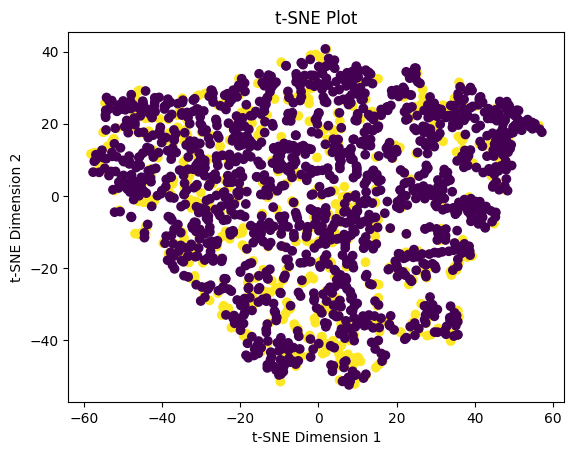

In [11]:
import matplotlib.pyplot as plt
# Plot t-SNE
plt.scatter(df_imp['coor_x'], df_imp['coor_y'], c= df_imp['Replication'])
plt.title('t-SNE Plot')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

## #4 Classify novel instances (POODLE)

### #4.1 Initialize variables for patient assignment

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

df_cluster = metadata_RA[['pseudoId','PhenoGraph_clusters']].copy()

# Construct patient similarity matrix from original set
sim_matrix = cosine_similarity(z_filtered.astype(np.float32))

# Specify columns for each modality (need to be present in both original & replication space)
d_input = {'cat' : list(df_categoric_replication[lcat].columns), 'num' : list(df_numeric_replication[lnum].columns)}

# Intialize list to save location of newly projected patients
z_new = []

# Define cluster
CLUSTER_LABEL = 'PhenoGraph_clusters'

# Initialize dataframe where we collect all predictors of interest for assigning patients to a cluster 
archetype_columns = ['weight_pval', 'weight_mean', 'weight_sd', 'cluster_mean_pat', 'cluster_sd_pat'] # + latent factors?
l_col = ['pseudoId', CLUSTER_LABEL]
for i in range(len(np.unique(df_cluster[CLUSTER_LABEL]))):
    l_col.extend(['%s_%s' % (col, i) for col in archetype_columns ])

df_characteristics = pd.DataFrame(columns=l_col)

### #4.2 Project the patients onto latent space and see how they are oriented

In [ ]:
import sys
sys.path.append(r'/exports/reum/tdmaarseveen/Poodle')
from poodle import utils as pup
import importlib as imp
imp.reload(pup)
np.seterr('raise') # reveal potential floating point errors

# Bookmark identifier (use fake)
df_id = pd.DataFrame({'pseudoId' : ['id_' + str(i) for i in range(len(df_numeric_replication))]})

for ix, new_pat in enumerate(df_id['pseudoId']):
    # collect sample information
    new_pat = str(df_id.iloc[ix]['pseudoId'])
    sample_cat = df_categoric_replication[lcat].iloc[ix]
    sample_num = df_numeric_replication[lnum].iloc[ix]
    sample = pd.concat([sample_cat, sample_num], axis=0)
    sample.name = new_pat

    # create metadata
    df_meta = pup.getMetaDataPatient(df_cluster, list(df_cluster['pseudoId'].values), new_pat)
    
    l_orientation = [df_id.iloc[ix]['pseudoId'], -1]
    
    # What is the orientation of the patient compared to each cluster
    # In other words, which cluster has the largest gravity on the patient
    l_orientation.extend(pup.getOrientation(autoencoder, df_meta, pd.DataFrame(z_filtered), d_input, sample, sim_matrix=sim_matrix, cluster_label='PhenoGraph_clusters'))

    # Bookmark cluster characteristics
    df_characteristics.loc[len(df_characteristics)] = l_orientation
    
df_characteristics['pseudoId'] = df_id['pseudoId'].copy()
df_characteristics.to_csv('../extractions/20240205_Clustering/ClusterCharacteristics_Projection_RZWN.csv', index=False, sep=',')
df_characteristics.head()

### #4.3 Build Poodle classifier

#### #4.3.1 Quantify orientation of original samples with respect to clusters

In [ ]:
import pandas as pd
import numpy as np
from math import exp
from scipy.stats import ttest_ind
from scipy.spatial.distance import cosine# cosine minkowski
from sklearn.metrics.pairwise import cosine_similarity
import sys
sys.path.append(r'/exports/reum/tdmaarseveen/Poodle')
from poodle import utils as pup
#import importlib as imp
#imp.reload(pup)
CLUSTER_LABEL = 'PhenoGraph_clusters'
# Initialize similarity matrix
# We only need to calculate the pairwise similarities of the initial space 1 time
sim_matrix = cosine_similarity(z_filtered.astype(np.float32))

df_characteristics_original = pup.quantifySimilarity(df_cluster, sim_matrix, CLUSTER_LABEL = 'PhenoGraph_clusters')
    
# Bookmark cluster characteristics
df_characteristics_original['pseudoId'] = df_cluster['pseudoId'].copy()
df_characteristics_original[CLUSTER_LABEL] = df_cluster[CLUSTER_LABEL].copy()
df_characteristics_original.to_csv('../extractions/20240205_Clustering/ClusterCharacteristics_Original.csv', index=False, sep=',')
df_characteristics_original.head()

#### #4.3.2 Optimize weights with simple classifier

TRAIN: [222 223 224 225 226 227 228 229 230 231] TEST: [0 1 2 3 4 5 6 7 8 9]
[13:53:05] WARNING: ../src/learner.cc:767: 
Parameters: { "n_trees" } are not used.

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [222 223 224 225 226 227 228 229 230 231]
[13:53:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_trees" } are not used.

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [444 445 446 447 448 449 450 451 452 453]
[13:53:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_trees" } are not used.

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [666 667 668 669 670 671 672 673 674 675]
[13:53:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_trees" } are not used.

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [888 889 890 891 892 893 894 895 896 897]
[13:53:07] WARNING: ../src/learner.cc:767: 
Parameters: { "n_trees" } are not used.



Text(0.5, 1.0, 'Confusion matrix for the Poodle labeler (XGB) on trainingsset (ACC: 1.00)')

<Figure size 640x480 with 0 Axes>

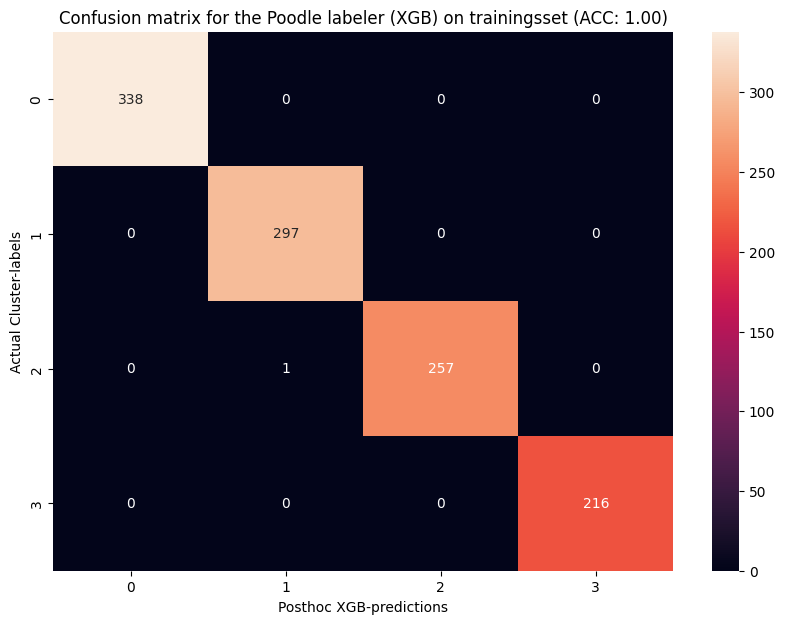

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import xgboost as xgb
import matplotlib.pyplot as plt
import time
import seaborn as sn
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

df_train, df_test = train_test_split(df_characteristics_original, test_size=0.2,  random_state=28072022) # stratify=df_characteristics['PhenoGraph_clusters'],

target = 'PhenoGraph_clusters'

cols_data = [x for x in list(df_train.columns) if x not in ['pseudoId', target]] #   'Sex', 'Age', 

X = df_train[cols_data].values
y = df_train[target]

# Apply 5 fold CV
kf = KFold(n_splits=5) # 
iteration = 0
y_pred = []
y_proba = []

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index[:10], "TEST:", test_index[:10])
    X_train, X_test = pd.DataFrame(X).loc[train_index], pd.DataFrame(X).loc[test_index]
    y_train, y_test = np.take(y, np.array(train_index)),np.take(y, np.array(test_index))#.values  # .values

    # Z-score scaling
    scaler = StandardScaler().fit(X_train)
    X_train= scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Model is an XGBClassifier
    n_trees = 50
    dmat_train = xgb.DMatrix(X_train, y_train)
    dmat_test = xgb.DMatrix(X_test, y_test)
    
    t0 = time.time()
    xgb_clf = xgb.XGBClassifier(objective='multi:softmax', eval_metric='merror', num_class=len(y.unique()), n_trees=50)
    xgb_clf = xgb_clf.fit(X_train, y_train)

    
    t1 = time.time()
    #print('Time for Training XGB model %s: %s' % (str(iteration+1), str(t1-t0)))
    iteration += 1
    
    # Create a confusion matrix over all data!
    #y_pred.extend(bst.predict(dmat_test))
    y_proba.extend(xgb_clf.predict_proba(X_test))
    y_pred.extend(xgb_clf.predict(X_test))
    
fig = plt.figure()
cm = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)


df_cm = pd.DataFrame(cm, index = list(range(len(y.unique()))),
                  columns = list(range(len(y.unique()))))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel("Posthoc XGB-predictions")
plt.ylabel("Actual Cluster-labels")
plt.title('Confusion matrix for the Poodle labeler (XGB) on trainingsset (ACC: %.2f)' % (accuracy))

#### #4.3.3 Show performance on hold-out test set

Text(0.5, 1.0, 'Confusion matrix for the Poodle labeler (XGB) in independent test set (ACC: 1.00)')

<Figure size 640x480 with 0 Axes>

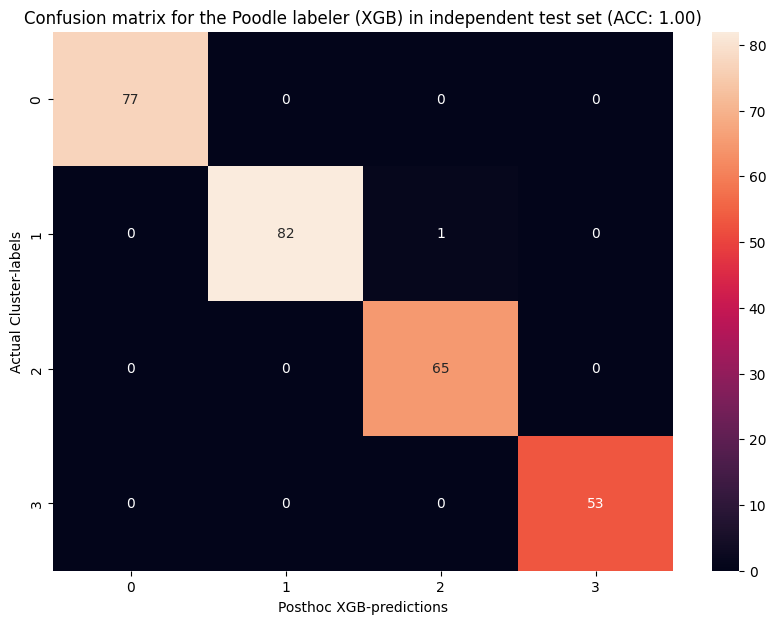

In [16]:
X_test_final = df_test[cols_data].values
y_test_final = df_test[target]

# Z-score scaling
#scaler = StandardScaler().fit(X_test)
X_test_final = scaler.transform(X_test_final)
y_pred_final = xgb_clf.predict(X_test_final)


fig = plt.figure()
cm = confusion_matrix(y_test_final, y_pred_final)
accuracy = accuracy_score(y_test_final, y_pred_final)


df_cm = pd.DataFrame(cm, index = list(range(len(y_test_final.unique()))),
                  columns = list(range(len(y_test_final.unique()))))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel("Posthoc XGB-predictions")
plt.ylabel("Actual Cluster-labels")
plt.title('Confusion matrix for the Poodle labeler (XGB) in independent test set (ACC: %.2f)' % (accuracy))

#### #4.3.4 Compare to dummy classifier

Text(0.5, 1.0, 'Confusion matrix for the Dummy labeler (XGB) in independent test set (ACC: 0.56)')

<Figure size 640x480 with 0 Axes>

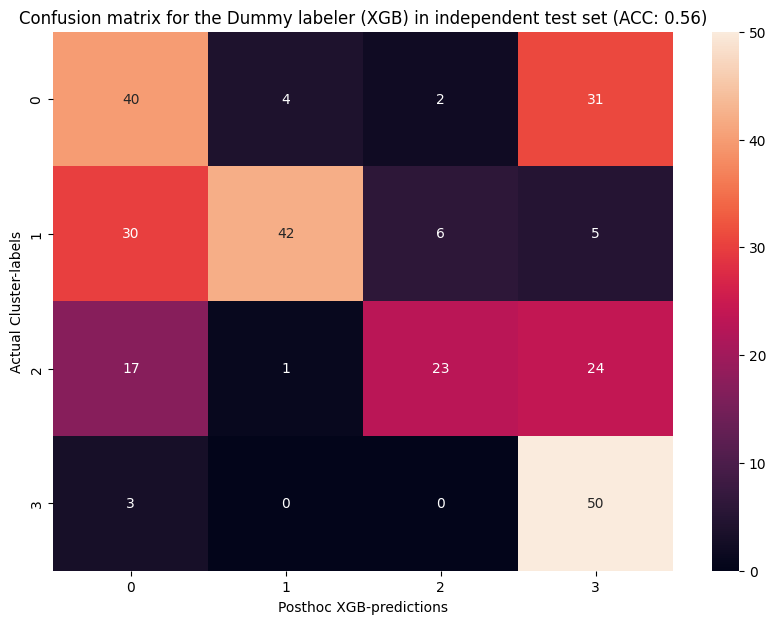

In [18]:
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score

def dummyLabeler(X):
    return np.argmax(X) # largest p

target = 'PhenoGraph_clusters'

X = df_test[[col for col in df_test.columns if 'weight_pval' in col]].copy()
y = df_test[target]

y_pred = []

for ix in range(len(X)): # loop through patients
    y_pred.append(dummyLabeler(X.iloc[ix]))

fig = plt.figure()
cm = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)

df_cm = pd.DataFrame(cm, index = list(range(len(y.unique()))),
                  columns = list(range(len(y.unique()))))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel("Posthoc XGB-predictions")
plt.ylabel("Actual Cluster-labels")
plt.title('Confusion matrix for the Dummy labeler (XGB) in independent test set (ACC: %.2f)' % (accuracy))

#### #4.3.5 Train final model on all labeled data & Save model

In [19]:
from sklearn.model_selection import KFold
import xgboost as xgb
import matplotlib.pyplot as plt

import time
import seaborn as sn
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from pickle import dump

X_all = df_characteristics_original[cols_data]
y_all = df_characteristics_original[CLUSTER_LABEL]

scaler = StandardScaler().fit(X_all)

X_all = scaler.transform(X_all)

dmat_train = xgb.DMatrix(X_all, y_all)

t0 = time.time()
bst  = xgb.train({'objective': 'multi:softmax',  'eval_metric':'merror', 'num_class':len(y.unique())}, dmat_train, # 'num_class':len(y.unique())
                    n_trees, evals=[(dmat_train, "train")]) # "tree_method": "gpu_hist", 'gamma': 8, , (dmat_test, "test")
t1 = time.time()

# save poodle labeler
bst.save_model("/exports/reum/tdmaarseveen/RA_Clustering/models/RZWN_poodle/xgb_model.json")

# save scaler
dump(scaler, open('/exports/reum/tdmaarseveen/RA_Clustering/models/RZWN_poodle/scaler.pkl', 'wb'))


[0]	train-merror:0.00000
[1]	train-merror:0.00000
[2]	train-merror:0.00000
[3]	train-merror:0.00000
[4]	train-merror:0.00000
[5]	train-merror:0.00000
[6]	train-merror:0.00000
[7]	train-merror:0.00000
[8]	train-merror:0.00000
[9]	train-merror:0.00000
[10]	train-merror:0.00000
[11]	train-merror:0.00000
[12]	train-merror:0.00000
[13]	train-merror:0.00000
[14]	train-merror:0.00000
[15]	train-merror:0.00000
[16]	train-merror:0.00000
[17]	train-merror:0.00000
[18]	train-merror:0.00000
[19]	train-merror:0.00000
[20]	train-merror:0.00000
[21]	train-merror:0.00000
[22]	train-merror:0.00000
[23]	train-merror:0.00000
[24]	train-merror:0.00000
[25]	train-merror:0.00000
[26]	train-merror:0.00000
[27]	train-merror:0.00000
[28]	train-merror:0.00000
[29]	train-merror:0.00000
[30]	train-merror:0.00000
[31]	train-merror:0.00000
[32]	train-merror:0.00000
[33]	train-merror:0.00000
[34]	train-merror:0.00000
[35]	train-merror:0.00000
[36]	train-merror:0.00000
[37]	train-merror:0.00000
[38]	train-merror:0.00

### #4.4 Use POODLE to cluster new instances

In [20]:
import sys
sys.path.append(r'../')
from poodle import utils as pup
import pandas as pd
from pickle import load

df_new = pd.read_csv('../extractions/20240205_Clustering/ClusterCharacteristics_Projection_RZWN.csv', sep=',')

# Define input columns
target = 'PhenoGraph_clusters'
cols_data = [x for x in list(df_new.columns) if x not in ['pseudoId', target]]

# Classify patients
X_replication = df_new[cols_data]#.

# load the scaler
scaler = load(open('/exports/reum/tdmaarseveen/RA_Clustering/models/RZWN_poodle/scaler.pkl', 'rb'))
#X_replication = scaler.transform(X_replication)

df_new['PhenoGraph_clusters'] = pup.classifyPatient(X_replication, path="/exports/reum/tdmaarseveen/RA_Clustering/models/RZWN_poodle/")
df_new.to_csv('../extractions/20240205_Clustering/ClusterAssignment_RZWN.csv', index=False, sep=',')
df_new.head()

,pseudoId,PhenoGraph_clusters,weight_pval_0,weight_mean_0,weight_sd_0,cluster_mean_pat_0,cluster_sd_pat_0,weight_pval_1,weight_mean_1,weight_sd_1,...,weight_pval_2,weight_mean_2,weight_sd_2,cluster_mean_pat_2,cluster_sd_pat_2,weight_pval_3,weight_mean_3,weight_sd_3,cluster_mean_pat_3,cluster_sd_pat_3
0,id_0,2.0,1.000000,0.882829,0.085086,0.912656,0.062842,0.000001,0.940169,0.043487,...,0.821562,0.905765,0.061719,0.908827,0.059364,1.000000,0.77727,0.146375,0.862446,0.079524
1,id_1,1.0,0.000001,0.882829,0.085086,0.850908,0.066875,0.999989,0.940169,0.043487,...,0.000002,0.905765,0.061719,0.887857,0.068783,0.000001,0.77727,0.146375,0.698461,0.118620
2,id_2,2.0,1.000000,0.882829,0.085086,0.902177,0.063949,0.000001,0.940169,0.043487,...,0.725132,0.905765,0.061719,0.907592,0.054544,1.000000,0.77727,0.146375,0.812142,0.101710
3,id_3,1.0,0.204369,0.882829,0.085086,0.880213,0.064096,1.000000,0.940169,0.043487,...,0.000001,0.905765,0.061719,0.876932,0.074687,0.000001,0.77727,0.146375,0.719678,0.121140
4,id_4,2.0,0.593574,0.882829,0.085086,0.883774,0.080924,0.000001,0.940169,0.043487,...,0.000018,0.905765,0.061719,0.891869,0.059373,1.000000,0.77727,0.146375,0.829999,0.109135


### #4.5 Show spatial variance

In [21]:
import pandas as pd
df_new = pd.read_csv('../extractions/20240205_Clustering/ClusterAssignment_RZWN.csv', sep=',')
df_new

,pseudoId,PhenoGraph_clusters,weight_pval_0,weight_mean_0,weight_sd_0,cluster_mean_pat_0,cluster_sd_pat_0,weight_pval_1,weight_mean_1,weight_sd_1,...,weight_pval_2,weight_mean_2,weight_sd_2,cluster_mean_pat_2,cluster_sd_pat_2,weight_pval_3,weight_mean_3,weight_sd_3,cluster_mean_pat_3,cluster_sd_pat_3
0,id_0,2.0,1.000000,0.882829,0.085086,0.912656,0.062842,0.000001,0.940169,0.043487,...,0.821562,0.905765,0.061719,0.908827,0.059364,1.000000,0.77727,0.146375,0.862446,0.079524
1,id_1,1.0,0.000001,0.882829,0.085086,0.850908,0.066875,0.999989,0.940169,0.043487,...,0.000002,0.905765,0.061719,0.887857,0.068783,0.000001,0.77727,0.146375,0.698461,0.118620
2,id_2,2.0,1.000000,0.882829,0.085086,0.902177,0.063949,0.000001,0.940169,0.043487,...,0.725132,0.905765,0.061719,0.907592,0.054544,1.000000,0.77727,0.146375,0.812142,0.101710
3,id_3,1.0,0.204369,0.882829,0.085086,0.880213,0.064096,1.000000,0.940169,0.043487,...,0.000001,0.905765,0.061719,0.876932,0.074687,0.000001,0.77727,0.146375,0.719678,0.121140
4,id_4,2.0,0.593574,0.882829,0.085086,0.883774,0.080924,0.000001,0.940169,0.043487,...,0.000018,0.905765,0.061719,0.891869,0.059373,1.000000,0.77727,0.146375,0.829999,0.109135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,id_510,1.0,0.234338,0.882829,0.085086,0.880581,0.062796,1.000000,0.940169,0.043487,...,0.000487,0.905765,0.061719,0.892871,0.069345,0.000001,0.77727,0.146375,0.722742,0.113561
511,id_511,2.0,0.000001,0.882829,0.085086,0.860916,0.070528,0.000001,0.940169,0.043487,...,0.000001,0.905765,0.061719,0.874854,0.068969,0.000001,0.77727,0.146375,0.745819,0.104545
512,id_512,3.0,0.000001,0.882829,0.085086,0.770242,0.112300,0.000001,0.940169,0.043487,...,0.000001,0.905765,0.061719,0.789416,0.086530,1.000000,0.77727,0.146375,0.819267,0.118436
513,id_513,0.0,1.000000,0.882829,0.085086,0.902761,0.076003,0.000001,0.940169,0.043487,...,0.000001,0.905765,0.061719,0.817051,0.086433,1.000000,0.77727,0.146375,0.831388,0.118903


In [22]:
import pandas as pd
df_new = pd.read_csv('../extractions/20240205_Clustering/ClusterAssignment_RZWN.csv', sep=',')

# Original clustering information (same samples as development set)
df_cluster = metadata_RA[['pseudoId', 'PhenoGraph_clusters']].copy()

Spatial variance in LEIDEN EHR set: 	C1= 415; C2= 380; C3= 323; C4= 269
Spatial variance in IMPROVED set: 	C1= 90; C2= 102; C3= 50; C4= 65
Spatial variance in RZWN set: 		C1= 91; C2= 279; C3= 77; C4= 68


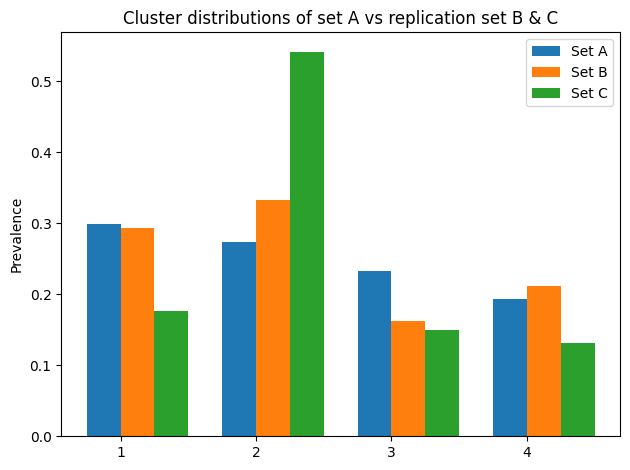

In [23]:
from collections import Counter
import matplotlib.pyplot as plt
import sys
sys.path.append(r'/exports/reum/tdmaarseveen/Poodle')
from poodle import visualization as viz


c = Counter(df_cluster['PhenoGraph_clusters'])
l_old = [c[ix]/sum(c.values()) for ix in range(0,len(c))]
print('Spatial variance in LEIDEN EHR set: \tC' + '; C'.join([str(ix+1) + '= ' + str(c[ix]) for ix in range(0,len(c))]))
l_improved = [90, 102, 50, 65]
print('Spatial variance in IMPROVED set: \tC' + '; C'.join([str(ix+1) + '= ' + str(l_improved[ix]) for ix in range(0,len(l_improved))]))
l_improved = [l_improved[ix]/sum(l_improved) for ix in range(0,len(l_improved))]
c = Counter(df_new['PhenoGraph_clusters'])
l_new = [c[ix]/sum(c.values()) for ix in range(0,len(c))]
print('Spatial variance in RZWN set: \t\tC' + '; C'.join([str(ix+1) + '= ' + str(c[ix]) for ix in range(0,len(c))]))

#viz.plotSpatialVariation(l_new, l_old)

x = np.arange(1, len(l_new)+1)  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, l_old, width, label='Set A')
rects2 = ax.bar(x + width/2, l_improved, width, label='Set B')
rects3 = ax.bar(x + width*1.5 , l_new, width, label='Set C')

title = 'Cluster distributions of set A vs replication set B & C'

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Prevalence')
ax.set_title(title)
ax.set_xticks(x)
ax.legend()

fig.tight_layout()

plt.show()

### previous::

Spatial variance in LEIDEN EHR set: 	C1= 415; C2= 380; C3= 323; C4= 269
Spatial variance in IMPROVED set: 	C1= 90; C2= 102; C3= 50; C4= 65
Spatial variance in RZWN set: 		C1= 91; C2= 279; C3= 77; C4= 68


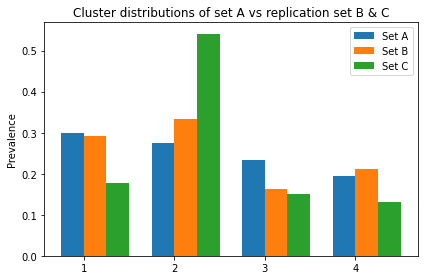

In [39]:
from collections import Counter
import matplotlib.pyplot as plt
import sys
sys.path.append(r'/exports/reum/tdmaarseveen/Poodle')
from poodle import visualization as viz


c = Counter(df_cluster['PhenoGraph_clusters'])
l_old = [c[ix]/sum(c.values()) for ix in range(0,len(c))]
print('Spatial variance in LEIDEN EHR set: \tC' + '; C'.join([str(ix+1) + '= ' + str(c[ix]) for ix in range(0,len(c))]))
l_improved = [90, 102, 50, 65]
print('Spatial variance in IMPROVED set: \tC' + '; C'.join([str(ix+1) + '= ' + str(l_improved[ix]) for ix in range(0,len(l_improved))]))
l_improved = [l_improved[ix]/sum(l_improved) for ix in range(0,len(l_improved))]
c = Counter(df_new['PhenoGraph_clusters'])
l_new = [c[ix]/sum(c.values()) for ix in range(0,len(c))]
print('Spatial variance in RZWN set: \t\tC' + '; C'.join([str(ix+1) + '= ' + str(c[ix]) for ix in range(0,len(c))]))

#viz.plotSpatialVariation(l_new, l_old)

x = np.arange(1, len(l_new)+1)  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, l_old, width, label='Set A')
rects2 = ax.bar(x + width/2, l_improved, width, label='Set B')
rects3 = ax.bar(x + width*1.5 , l_new, width, label='Set C')

title = 'Cluster distributions of set A vs replication set B & C'

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Prevalence')
ax.set_title(title)
ax.set_xticks(x)
ax.legend()

fig.tight_layout()

plt.show()

### 4.6 Show gestalt plot of original

In [24]:
import importlib as imp
import sys
sys.path.append(r'/exports/reum/tdmaarseveen/RA_Clustering/src/1_emr_scripts')
import MannequinFunctions as func
imp.reload(func)

<module 'MannequinFunctions' from '/exports/reum/tdmaarseveen/RA_Clustering/src/1_emr_scripts/MannequinFunctions.py'>

In [ ]:
CLUSTER =0
# Import mannequin information
df_man = pd.read_csv('../extractions/20240205_Clustering/Metadata_complete.csv', sep='|')
#df_cluster['PATNR']=df_cluster['pseudoId'].copy()
l_pat = set(df_cluster[df_cluster['PhenoGraph_clusters']==CLUSTER]['patnr'])
df_sub = df_man[df_man['pseudoId'].isin(l_pat)].copy()

#create scatterplot (toDo: for both big & small joints)
#l_col = [col for col in df_sub.columns if col not in ['pseudoId', 'patnr','FirstConsult', 'PATNR']]
l_mannequin = [col for col in df_imp.columns if ((('Zwelling_' in col or 'Pijn_' in col)) and 'positive' in col)]
df_plot = pd.DataFrame(df_sub[l_mannequin].mean().T)
df_plot= df_plot.reset_index()
df_plot.columns = ['feature', 'value']
df_plot['x'], df_plot['y'], df_plot['s'] = zip(*df_plot['feature'].apply(lambda x : func.get_mannequin_coord(x)))
df_plot['s'] = df_plot['s'] #* df_plot['value']

# Visualize gestalt
im = plt.imread('/exports/reum/tdmaarseveen/RA_Clustering/figures/2_processing/Mannequin_large_old.jpg')
implot = plt.imshow(im)
plt.scatter(df_plot.x, df_plot.y, s=df_plot.s, c=df_plot.value, cmap='autumn_r')
fig = plt.gcf()
fig.set_dpi(100)
#plt.text(450, 1, r'Cluster %s' % str(CLUSTER+1), fontsize=15)
plt.axis('off')

### #4.7 Visualize Projection on Patient embedding

In [26]:
import sys
sys.path.append(r'../')
sys.path.append(r'/exports/reum/tdmaarseveen/Poodle')
from poodle import utils as pup
import pandas as pd
import numpy as np

df_z = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/results/embedding/RZWN_embedding_projections.csv', sep=',')
l_embedding = [col for col in df_z.columns]

# Variables from replication set
df_projection = pd.read_csv('../extractions/20240205_Clustering/ClusterAssignment_RZWN.csv', sep=',')

# import metadata of SyG replication set
metadata_rep = pd.read_csv('../extractions/20240205_Clustering/metadata_rzwn.csv', sep='|')
metadata_rep['Replication'] = 1
# add cluster info for projected patietns
metadata_rep['PhenoGraph_clusters'] = df_projection['PhenoGraph_clusters'].copy() # len(metadata['PhenoGraph_clusters'].unique())+1


# import metadata of development set
metadata_RA = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/MMAE_clustering_270.csv', index_col=0) #  pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/5_clustering/df_metadata.csv')
metadata_RA['Replication'] = 0

# Combine both metadatas
metadata = metadata_RA.append(metadata_rep, ignore_index = True)

# Add projected patients to original set
l_latent = [col for col in l_embedding if col not in ['pseudoId', 'PATNR']]

print('BEFORE: total samples for tsne: ', len(metadata_RA))
metadata_total, z_total = pup.add_projected_patients(metadata_RA, pd.DataFrame(z_filtered, columns=l_latent), metadata_rep, z_patient[l_latent]) # ix = 
print('After: total samples for tsne: ', len(metadata_total))

metadata_total.to_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/RZWN_Complete_META.csv', sep=';', index=None)

/tmp/ipykernel_721984/15492966.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metadata = metadata_RA.append(metadata_rep, ignore_index = True)


BEFORE: total samples for tsne:  1387
After: total samples for tsne:  1902


#### #4.7.1 train parametric umap

In [58]:
from umap.parametric_umap import ParametricUMAP
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import importlib as imp


# Define the encoder model
def create_encoder(input_dim, latent_dim):
    input_layer = Input(shape=(input_dim,))
    x = Dense(128, activation='sigmoid')(input_layer) # sigmoid
    x = Dense(64, activation='sigmoid')(x)
    x = Dense(32, activation='sigmoid')(x)
    latent_space = Dense(latent_dim)(x)  # No activation in the output layer

    return Model(input_layer, latent_space, name='encoder')
 
# Parameters
input_dim = 8
latent_dim = 2  # Target dimension for UMAP

encoder = create_encoder(input_dim, latent_dim)
encoder.summary()

keras_fit_kwargs = {"callbacks": [
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        min_delta=10**-4,
        patience=10,
        verbose=1,
    )
]}

SEED = 2024061572

embedder = ParametricUMAP(random_state=SEED, keras_fit_kwargs=keras_fit_kwargs, encoder=encoder, n_training_epochs=10) #
embedding = embedder.fit_transform(z_filtered)
pup.plot_tsne(embedding, group_id=metadata_RA['PhenoGraph_clusters'], path='../figures/projection/umap_original_RZWN.png')

# save parametric UMAP
embedder.save('../model/umap/umap_mapping_RZWN')

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 8)]               0         
_________________________________________________________________
dense_49 (Dense)             (None, 128)               1152      
_________________________________________________________________
dense_50 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_51 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_52 (Dense)             (None, 2)                 66        
Total params: 11,554
Trainable params: 11,554
Non-trainable params: 0
_________________________________________________________________


/exports/reum/tdmaarseveen/envs/mmae/envs/ae_training/lib/python3.8/site-packages/umap/parametric_umap.py:269: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  warn(


Epoch 1/100
17/17 [==============================] - 1s 64ms/step - loss: 2.7368
Epoch 2/100
17/17 [==============================] - 1s 65ms/step - loss: 1.3141
Epoch 3/100
17/17 [==============================] - 1s 65ms/step - loss: 0.8085
Epoch 4/100
17/17 [==============================] - 1s 66ms/step - loss: 0.5832
Epoch 5/100
17/17 [==============================] - 1s 65ms/step - loss: 0.4810
Epoch 6/100
17/17 [==============================] - 1s 65ms/step - loss: 0.4411
Epoch 7/100
17/17 [==============================] - 1s 65ms/step - loss: 0.4125
Epoch 8/100
17/17 [==============================] - 1s 65ms/step - loss: 0.3938
Epoch 9/100
17/17 [==============================] - 1s 65ms/step - loss: 0.3830
Epoch 10/100
17/17 [==============================] - 1s 65ms/step - loss: 0.3754
Epoch 11/100
17/17 [==============================] - 1s 65ms/step - loss: 0.3675
Epoch 12/100
17/17 [==============================] - 1s 67ms/step - loss: 0.3600
Epoch 13/100
17/17 [=====

#### #4.7.2 Project both original and replication samples

In [59]:
# Project replication data onto tSNE
fit2 = embedder.transform(z_total.values)

# Plot Umap as 2d image
pup.plot_tsne(fit2, group_id=metadata_total['Replication'], path='../figures/projection/umap_replication_projected_RZWN.png')


In [60]:
sys.path.append(r'../../src/1_emr_scripts')
import Visualization as func
l_cat = [col for col in df_categoric_replication.columns if col not in ['PATNR','RF' , 'Age_Early', 'Age_Late']]

# update column
#df_imp['PATNR'] = df_z['PATNR'].astype(str).copy()
metadata_total['Replication'] = metadata_total['Replication'].astype(float)

#df_imp['Age_Early'] = df_imp['Age_Early'].fillna(0)
##df_imp['Age_Late'] =df_imp['Age_Late'].fillna(0)
metadata_total = metadata_total.fillna(0)

l_cat_spec = ['RF']
l_cat_spec.extend(l_cat)
#l_cat_spec.extend(l_cat_patnr)
#l_cat_spec = l_cat_spec[:-3]
#l_cat_spec.append('patnr')
l_cat_spec.append('Replication')
l_cat_spec.append('PATNR')
l_cat_spec.append('PhenoGraph_clusters')
l_cat_spec.append('Age')
l_cat_spec.append('BSE')
l_cat_spec.append('SJC')
l_cat_spec.append('TJC')

#l_cat_spec.pop(-5)


# Save embedding + projection
#df_z.to_csv('/exports/reum/tdmaarseveen/RA_Clustering/results/embedding/RZWN_embedding_projections.csv', index=False, sep=',')

# Important to start with RF -> (why i do not knwo)
#(X_embedded, df_imp[l_cat_spec],  l_cat_spec, l_binary=l_cat_spec, patient_id='patnr', cluster_id='RF', title='MMAE_UMAP2',  path='../tsne/RZWN_MMAE.html')
func.visualize_umap_bokeh_na_2(fit2, metadata_total[l_cat_spec],  l_cat_spec, l_binary=l_cat_spec, patient_id='PATNR', cluster_id='PhenoGraph_clusters', title='MMAE_UMAP2', path='../tsne/RZWN_MMAE_clustered.html')

1902 1902
0 []

UMAP figure saved under location: TSNE/Baseline_MMAE_UMAP2.html


### add information on treatment delay? 


In [ ]:
import pandas as pd

df_treat = pd.read_csv('../proc/ZWN_TreatmentResponseTable.csv', sep=';')
df_treat = df_treat.sort_values(by='StartDateTreatment')
d_drugStart = dict(zip(df_treat.drop_duplicates(subset=['patnr'])['patnr'], df_treat.drop_duplicates(subset=['patnr'])['StartDateTreatment']))
d_drugStart

### 4.8 Show characteristics of clusters

#### 4.8.1 create baseline table

In [15]:
import numpy as np

def IQR(data):
    if np.__version__ != '1.19.5':
        Q1 = np.percentile(data, 25, method = 'midpoint') # or method in later version
        Q3 = np.percentile(data, 75, method = 'midpoint')
    else : 
        Q1 = np.percentile(data, 25, interpolation = 'midpoint') # or method in later version
        Q3 = np.percentile(data, 75, interpolation = 'midpoint')

    # Interquaritle range (IQR)
    iqr = Q3 - Q1
    return [Q1, Q3]

def calculate_DAS28(tjc, sjc, esr):
    """
    Calculate DAS28 with 3 variables : TJC, SJC and ESR (BSE)
    """
    #print(esr, tjc, sjc)
    if esr != 0.0:
        das28 = (0.56 * np.sqrt(tjc) + 0.28 * np.sqrt(sjc) + 0.70 * np.log(esr)) * 1.08 + 0.16
    else :
        das28 = np.nan
        print(esr, tjc, sjc)
        #print(eql)
    #print(das28)
    return das28

def calculate_DAS44(tjc, sjc, esr):
    """
    Calculate DAS44 with 3 variables : RAI, SJC and ESR (BSE)
    """
    if esr != 0.0:
        das44= (0.53938 * np.sqrt(tjc) + 0.0650 * (sjc) + 0.330 * np.log(esr)) + 0.224 
    else :
        das44 = np.nan
        print(esr, tjc, sjc)
    return das44

# Of df_repl_meta? 
#df_replication = metadata_rep.copy()
df_replication['DAS28'] = df_replication.apply(lambda x : calculate_DAS28(x['TJC'], x['SJC'], x['BSE']), axis=1)
df_replication['DAS44']  = df_replication.apply(lambda x : calculate_DAS44(x['TJC'], x['SJC'], x['BSE']), axis=1)

# Get more insight into Mannequin by visualizing the ratios
df_replication['Swollen ratio'] = df_replication['SJC'] / (df_replication['SJC']+df_replication['TJC'])
df_replication['Swollen ratio'] = df_replication['Swollen ratio'].fillna(0) 
df_replication['Tender ratio'] = df_replication['TJC'] / (df_replication['SJC']+df_replication['TJC'])
df_replication['Tender ratio'] = df_replication['Tender ratio'].fillna(0)


# 'DAS44 (median+-IQR)', 'SJC (median+-IQR)', 'TJC (median+-IQR)','MTX [n(%)]', 'Symptom duration (median+-IQR, days)', 'Symptom duration NA [n(%)]', 'No DMARD info [n(%)]', 'Small joints (median+-IQR)', 'Big joints (median+-IQR)', 'Symmetrical joints (median+-IQR)' ]) # , 'Symptom duration (median+-IQR, days)' 'prevalence_
df_baseline = pd.DataFrame(columns=['cluster', 'N', 'Sex [n(%)]', 'RF [n(%)]', 'aCCP [n(%)]',  'ESR (median+-IQR, mm/hr)', 'Age (mean+-SD, yr)', 'SJC (median+-IQR)', 'TJC (median+-IQR)',  'DAS28 (median+-IQR)', 'DAS44 (median+-IQR)', 'Follow Up (median+-IQR)']) #TreatSwitch [n(%)]',  'Feet (median+-IQR)', 'remission_6mo [n(%)]','Low_DAS_6mo [n(%)]'
# 'final_DAS28 (median+-IQR)', 
col_cluster = 'PhenoGraph_clusters'
df_replication[col_cluster] = df_replication[col_cluster]  #+ 1
df_replication.to_csv('../extractions/20240205_Clustering/BaselinePopulation_RZWN.csv', sep=';')

for cluster in df_replication[col_cluster].unique():
    #print(cluster)
    sub_df = df_replication[df_replication[col_cluster]==cluster].copy() 
    df_baseline.loc[len(df_baseline)] = [cluster, '%.2f' % len( sub_df), '%.0f (%.1f)' % (np.sum(sub_df['Sex']), np.mean(sub_df['Sex']) * 100), '%.0f (%.1f)' % (np.sum(sub_df['RF']), np.mean(sub_df['RF']) * 100), '%.0f (%.1f)' % (np.sum(sub_df['aCCP']), np.mean(sub_df['aCCP']) * 100), '%.0f (%.0f-%.0f)' % (np.median(sub_df['BSE']), IQR(sub_df['BSE'])[0], IQR(sub_df['BSE'])[1]), '%.1f (%.1f)' % (np.mean(sub_df['Age']), np.std(sub_df['Age'])),
                                         '%.0f (%.0f-%.0f)' % (np.median(sub_df['SJC']), IQR(sub_df['SJC'])[0], IQR(sub_df['SJC'])[1]),
                                         '%.0f (%.0f-%.0f)' % (np.median(sub_df['TJC']), IQR(sub_df['TJC'])[0], IQR(sub_df['TJC'])[1]),
                                         '%.1f (%.1f-%.1f)' % (np.median(sub_df[~sub_df['DAS28'].isna()]['DAS28']), IQR(sub_df[~sub_df['DAS28'].isna()]['DAS28'])[0], IQR(sub_df[~sub_df['DAS28'].isna()]['DAS28'])[1]),
                                         '%.1f (%.1f-%.1f)' % (np.median(sub_df[~sub_df['DAS44'].isna()]['DAS44']), IQR(sub_df[~sub_df['DAS44'].isna()]['DAS44'])[0], IQR(sub_df[~sub_df['DAS44'].isna()]['DAS44'])[1]),
                                         '%.0f (%.0f-%.0f)' % (np.median(sub_df['FollowUp']), IQR(sub_df['FollowUp'])[0], IQR(sub_df['FollowUp'])[1]),
                                         #'%.1f (%.1f-%.1f)' % (np.median(sub_df['Feet-%']), IQR(sub_df['Feet-%'])[0], IQR(sub_df['Feet-%'])[1]),
                                         
                                        ]

df_baseline = df_baseline.sort_values(by='cluster').reset_index(drop=True)
if 0 in df_baseline['cluster'].unique(): 
    df_baseline['cluster'] += 1
#df_baseline.set_index('cluster').T.to_csv('../extractions/20240205_Clustering/ClusterTable_RZWN_MMAE_unsupervised.csv', sep=';')
df_baseline.set_index('cluster').T

cluster,1.0,2.0,3.0,4.0
N,46.00,186.00,30.00,32.00
Sex [n(%)],33 (71.7),113 (60.8),15 (50.0),24 (75.0)
RF [n(%)],34 (73.9),128 (68.8),17 (56.7),17 (53.1)
aCCP [n(%)],30 (65.2),107 (57.5),15 (50.0),15 (46.9)
"ESR (median+-IQR, mm/hr)",19 (8-32),17 (9-28),16 (10-34),18 (6-33)
"Age (mean+-SD, yr)",60.8 (14.2),61.8 (14.4),62.4 (14.6),56.4 (13.2)
SJC (median+-IQR),9 (6-12),2 (0-4),13 (8-16),18 (14-26)
TJC (median+-IQR),14 (10-17),3 (1-5),10 (7-18),20 (16-37)
DAS28 (median+-IQR),5.2 (4.6-6.3),3.7 (3.0-4.2),5.2 (4.6-5.7),6.3 (5.5-7.3)
DAS44 (median+-IQR),3.6 (3.2-4.4),2.2 (1.8-2.6),3.7 (3.3-4.1),4.7 (4.2-6.1)


In [ ]:
import pandas as pd
df_baseline = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/RZWN_Complete_META.csv', sep=';')
df_baseline[df_baseline['DAS44'].isna()] #.set_index('cluster').T

#### #3.8.2 Show gestalt plot

(-0.5, 1452.5, 1799.5, -0.5)

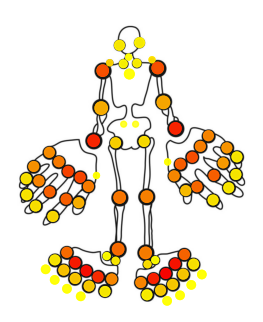

In [223]:
import importlib as imp
import sys
sys.path.append(r'/exports/reum/tdmaarseveen/RA_Clustering/src/1_emr_scripts')
import MannequinFunctions as func
import matplotlib.pyplot as plt
imp.reload(func)

CLUSTER =3
l_pat_cluster = set(df_replication[df_replication['PhenoGraph_clusters']==CLUSTER]['PATNR'])
#df_man = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/offshoots/ERC_SyG/SyG_metadata.csv', sep='|') 

#df_replication['index'] = df_replication['pseudoId'].copy()

df_sjc = df_man[(df_man['PATNR'].isin(l_pat_cluster))].copy()
df_sjc = df_sjc.fillna(0)
df_tjc = df_sjc.copy()


l_swollen = [col for col in df_man.columns if (('pseudoId' in col) or ('Zwelling_' in col and 'positive' in col) )]
l_tender = [col for col in df_man.columns if (('pseudoId' in col) or ('Pijn_' in col and 'positive' in col) )]

    
df_sjc = df_sjc[l_swollen]
df_tjc = df_tjc[l_tender]

df_total = pd.concat([df_sjc, df_tjc]).groupby('pseudoId', as_index=False).mean()

#create scatterplot (toDo: for both big & small joints)
l_col = [col for col in df_total.columns if col not in ['pseudoId', 'patnr','FirstConsult', 'index']]
df_plot = pd.DataFrame(df_total[l_col].mean().T)
df_plot= df_plot.reset_index()
df_plot.columns = ['feature', 'value']
df_plot['x'], df_plot['y'], df_plot['s'] = zip(*df_plot['feature'].apply(lambda x : func.get_mannequin_coord(x)))## func.
df_plot['s'] = df_plot['s'] * 0.6 #* 0.8* df_plot['value']

# Visualize gestalt
im = plt.imread('/exports/reum/tdmaarseveen/RA_Clustering/figures/2_processing/Mannequin_large_old.jpg')
implot = plt.imshow(im)
plt.scatter(df_plot.x, df_plot.y, s=df_plot.s, c=df_plot.value, alpha=0.8, cmap='autumn_r')
fig = plt.gcf()
fig.set_dpi(100)
#plt.text(450, 1, r'Cluster %s' % str(CLUSTER+1), fontsize=15)
plt.axis('off')

In [6]:
import pandas as pd

# Select patients of interest
metadata_total = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/RZWN_Complete_META.csv', sep=';')
metadata_repl = metadata_total[metadata_total['Replication']==1]

/tmp/ipykernel_748319/2358002625.py:4: DtypeWarning: Columns (383,384,385,388,390,391,392,393,394,397,398,400,401) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_total = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/RZWN_Complete_META.csv', sep=';')


## #5 Downstream survival analysis

### 5.1 Format medication

In [ ]:
import pandas as pd


metadata_total = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/RZWN_Complete_META.csv', sep=';')
metadata_total[((metadata_total['PhenoGraph_clusters']==0) & (metadata_total['Replication']==1))]

In [215]:
import pandas as pd

# Select patients of interest
metadata_total = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/7_final/RZWN_Complete_META.csv', sep=';')
metadata_total['FirstConsult'] = pd.to_datetime(metadata_total['FirstConsult'], format='%Y-%m-%d' )
df_replication = metadata_total[metadata_total['Replication']==1]
df_replication = df_replication.reset_index(drop=True)
l_final_pat = list(df_replication['PATNR'].unique())

# Bookmark first consult, follow up and cluster membership 
d_pec= dict(zip(df_replication['PATNR'], df_replication['FirstConsult']))
d_clust= dict(zip(df_replication['PATNR'], df_replication['PhenoGraph_clusters']))
d_fu = dict(zip(df_replication['PATNR'], df_replication['FollowUp']))

# Get Medication infor
df_med =pd.read_csv('../data/ZWN_dmard_voorschriften.csv', sep=',')
#df_med[df_med['Identifier']=='0009e8be-d91c-4989-a18a-21b3baf992a2']

# Select only those with RA 
df_med = df_med[df_med['Identifier'].isin(l_final_pat)].reset_index(drop=True) # [df_med['WerkzameStof']=='METHOTREXAAT']

# Read as pandas data
df_med['Startdatum'] = pd.to_datetime(df_med['Startdatum'], format='%Y-%m-%d')
# Remove time, keep only date
df_med['Startdatum'] = df_med['Startdatum'].dt.date
df_med['Startdatum'] = pd.to_datetime(df_med['Startdatum'], format='%Y-%m-%d')


# Maybe get PEC date instead? -> actual first consult 
#d_pseudo_date = dict(zip(df_med.sort_values(by='Startdatum', ascending=False).Identifier, df_med.sort_values(by='Startdatum', ascending=False).Startdatum))



/exports/reum/tdmaarseveen/custom_environment/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (383,384,385,388,390,391,392,393,394,397,398,400,401) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
import numpy as np

l_rx = ['TOCILIZUMAB', 'METHOTREXAAT', 'HYDROXYCHLOROQUINE',
       'AZATHIOPRINE', 'INFLIXIMAB', 'ABATACEPT',
       'SULFASALAZINE', 'ANAKINRA', 'ETANERCEPT', 'CICLOSPORINE',
       'LEFLUNOMIDE', 'CERTOLIZUMAB PEGOL', 'ADALIMUMAB', 'BARICITINIB',
        'GOLIMUMAB','AUROTHIOBARNSTEENZUUR', 'CYCLOFOSFAMIDE',
       'CHLOROQUINE', 'TOFACITINIB', 'PREDNISOLON', 'METHYLPREDNISOLON', 'PREDNISON', 'SARILUMAB', 'FILGOTINIB']

l_conv_dmard = ['SULFASALAZINE', 'METHOTREXAAT', 'HYDROXYCHLOROQUINE','LEFLUNOMIDE',  ]
l_dmard = ['TOCILIZUMAB', 'METHOTREXAAT', 'HYDROXYCHLOROQUINE',
       'AZATHIOPRINE', 'INFLIXIMAB', 'ABATACEPT',
       'SULFASALAZINE', 'ANAKINRA', 'ETANERCEPT', 'CICLOSPORINE',
       'LEFLUNOMIDE', 'CERTOLIZUMAB PEGOL', 'ADALIMUMAB', 'BARICITINIB',
        'GOLIMUMAB','AUROTHIOBARNSTEENZUUR', 'CYCLOFOSFAMIDE',
       'CHLOROQUINE', 'TOFACITINIB', 'SARILUMAB', 'FILGOTINIB']

l_pred = ['PREDNISOLON', 'METHYLPREDNISOLON', 'PREDNISON']

# Extract Medication from text if missing
df_med['MedicatieNaam'] = df_med['MedicatieNaam'].str.lower()
d_trans = {'FIL;TINIB' : 'FILGOTINIB', ';LIMUMAB' : 'GOLIMUMAB'}

for i in l_rx:
    df_med['WerkzameStof'] = df_med['WerkzameStof'].fillna(df_med['MedicatieNaam'].apply(lambda x: i.upper() if i.lower() in x else np.nan))
df_med['WerkzameStof'] = df_med['WerkzameStof'].replace(d_trans)

df_med = df_med.rename(columns = {'Identifier' : 'patnr', 'WerkzameStof' : 'drugName', 'Startdatum' : 'startDate'})
df_med['startDate'] = pd.to_datetime(df_med['startDate'], format='%Y-%m-%d', errors='ignore')
df_med['endDate'] = df_med['startDate'] + pd.Timedelta(days=30)


df_med = df_med.sort_values(by=['patnr', 'startDate']).reset_index(drop=True)

df_med

In [ ]:
import pandas as pd
import numpy as np

def create_treatment_table(df_med, d_pseudo_date):
    """
    Create a table for downstream analysis of treatment response
    
    Input:
        - df_med = processed table with Medication information
        - d_pseudo_date = dictionary of pseudo ids linked to first dates
    Output:
        - df_treat = composite table with DAS28(3) combined with current treatment information
    """
    df_treat = pd.DataFrame(columns=['patnr', 'treatID', 'Drug','StartDateTreatment', 'EndDateTreatment', 'daysTreatment', 'extractDate']) # columns=['patnr', 'DAS28(3)', 'CurTreatment', 'Dosage', 'date', 'days', 'daysCurTreatment'
    tol = 1
    
    for patnr in df_med['patnr'].unique():
        print(patnr)
        no_med = True # register if medication is found
        missing_baseline = False
        
        ix = 0
        
        # Create subset of medication table
        sub_df = df_med[df_med['patnr']==patnr].copy()
        sub_df = sub_df.sort_values(by='startDate')
                
        # Get first date associated with the pseudoId
        first_date = pd.to_datetime(d_pseudo_date[patnr], format='%Y-%m-%d', errors='ignore')
        
        #l_med = []
        
        for ix, drug in enumerate(sub_df['drugName'].values):
            startDate = sub_df['startDate'].iloc[ix]
            endDate = sub_df['endDate'].iloc[ix]
            delta_days = pd.to_datetime(startDate, format='%Y-%m-%d', errors='ignore') - first_date
            delta_days = delta_days.days
            #df_treat.loc[len(df_treat)] = [patnr, '%s_%s' % (patnr, ix), sub_df['drugName'].iloc[ix], sub_df['extractDose'].iloc[ix], sub_df['extractUnit'].iloc[ix], sub_df['instruction'].iloc[ix], sub_df['startDate'].iloc[ix], sub_df['endDate'].iloc[ix], delta_days]
            
            #if len(cor_das) == 0: # bookkeeping Medication
            #    l_med.append(ix)
            #print(eql)
        #for ix in l_med:
            df_treat.loc[len(df_treat)] = [patnr, '%s_%s' % (patnr, ix), sub_df['drugName'].iloc[ix], sub_df['startDate'].iloc[ix], sub_df['endDate'].iloc[ix], delta_days, sub_df['startDate'].iloc[ix]]
    
    df_treat = df_treat.sort_values(by='extractDate').reset_index(drop=True)
    return df_treat 

# Create composite tables
df_treat = create_treatment_table(df_med, d_pec)
df_treat.to_csv('../proc/ZWN_TreatmentResponseTable.csv', sep=';', index=False)

### 5.2 Format to response table 

In [ ]:
import sys
import StudyRx as rx
import importlib as imp
imp.reload(rx)

# Load treatment data / Medicator
df_treat = pd.read_csv('../proc/ZWN_TreatmentResponseTable.csv', sep=';')
df_treat = df_treat[~df_treat['Drug'].isna()]

df_response = pd.DataFrame(columns=['patnr', 'Treatment', 'NextTreatment', 'Treatment_shift', 'MTX-starter', 'Cluster', 'firstDateSwitch', 'totalFollowUp', 'firstConsult'])

for patnr in df_treat['patnr'].unique():
    firstConsult = d_pec[patnr]
    cluster = d_clust[patnr]
    Followup = d_fu[patnr]
    
    # 93    
    # sometimes tiny gaps # 87
    df_ligated, df_ghost = rx.getTrajectoryRX(df_treat[df_treat['patnr']==patnr], tol=88, figure=0) # 183 , time_window=(1800, 2000) 304844513_0 304829560_0 # , time_window=(2231, 3611)
    df_ligated = df_ligated[df_ligated['Time']>1].reset_index(drop=True)
    
    if len(df_ligated) > 1:
        Treatment_shift = len(df_ligated['Drug'].unique()) > 1
        firstDrug =df_ligated.iloc[0]['Drug']
        MTX_starter  = 'METHOTREXAAT' in firstDrug 
        if Treatment_shift:
            df_ligated = df_ligated.drop_duplicates(subset=['Drug']).reset_index()
            firstDateSwitch = df_ligated.iloc[1]['Start'] # df_ligated.iloc[1]['Start']
            NextDrug =df_ligated.iloc[1]['Drug']
            if NextDrug == firstDrug:
                print(NextDrug, firstDrug, df_ligated)
        else : 
            firstDateSwitch = np.nan
            NextDrug = firstDrug
    else : 
        firstDateSwitch = np.nan
        NextDrug = firstDrug
    df_response.loc[len(df_response)] = [patnr, firstDrug, NextDrug, Treatment_shift, MTX_starter, cluster, firstDateSwitch, Followup, firstConsult]

df_response.to_csv('../proc/SummaryResponseTable_RZWN2.csv', sep=';', index=False)
#df_response.to_csv('../proc/SummaryResponseTable_RZWN.csv', sep=';', index=False) # SummaryResponseTable_maui_4 SummaryResponseTable2= MOFA,
df_response

In [ ]:
import pandas as pd
import sys
import StudyRx as rx
import importlib as imp
imp.reload(rx)


df_treat = pd.read_csv('../proc/ZWN_TreatmentResponseTable.csv', sep=';')
#df_treat = pd.read_csv('../proc/SummaryResponseTable_RZWN.csv', sep=';') # SummaryResponseTable_maui_4 SummaryResponseTable2= MOFA,
df_treat['pseudoId'] = df_treat['patnr'].copy()
df_treat['Drug'] = df_treat['Drug'].fillna('')

df_effective, df_drugs, df_inferred = rx.getTableEffectiveRX(df_treat, verbose=True, output=True)
df_effective.to_csv('../proc/EffectiveDrugInformation.csv', index=False)
df_inferred.to_csv('../proc/DrugInformation.csv', index=False)

### 5.3 Succesrate final drug

In [101]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pandas as pd
import plotly.graph_objects as go

def isBiological(row):
    l_biological = ['ETA', 'ADA', 'INF', 'CERTO', 'GOL', 'ABA', 'TCZ', 'RTX', 'BARI', 'TOFA', 'GOUD']
    biological = 0
    # if we find just one biological -> return True
    if row['All_prescriptions'] == row['All_prescriptions']: # check if not nan
        for drug in l_biological:
            if drug in row['All_prescriptions']:
                biological = 1
                break    
        return biological
    else :
        return np.nan # return nan

d_acronym = {'ABATACEPT' : 'ABA', 'ADALIMUMAB' : 'ADA', 'AZATHIOPRINE' : 'AZA','AUROTHIOBARNSTEENZUUR (DI-NA-ZOUT)' : 'GOUD',  'CERTOLIZUMAB PEGOL': 'CER', 'BARICITINIB': 'BARI', 'CERTOLIZUMAB' :'CERTO',  'ETANERCEPT' : 'ETA', 'GOLIMUMAB' : 'GOL', 'HYDROXYCHLOROQUINE':'HQL', 'INFLIXIMAB' : 'INF', 'LEFLUNOMIDE' : 'LEF', 'METHOTREXAAT' : 'MTX', 'RITUXIMAB' : 'RTX', 'SULFASALAZINE' : 'SSZ', 'TOCILIZUMAB' : 'TCZ', 'TOFACITINIB' : 'TOFA'}
l_biological = ['ABATACEPT', 'ADALIMUMAB', 'AUROTHIOBARNSTEENZUUR (DI-NA-ZOUT)', 'AZATHIOPRINE',  'BARICITINIB', 'CERTOLIZUMAB', 'ETANERCEPT', 'GOLIMUMAB', 'INFLIXIMAB', 'RITUXIMAB', 'TOCILIZUMAB', 'TOFACITINIB']

# Import drug data  
df_drug = pd.read_csv('../proc/EffectiveDrugInformation.csv', sep=',')
d_drug = dict(zip(df_drug.pseudoId, df_drug.Drug))
d_time_on_drug = dict(zip(df_drug.pseudoId, df_drug.Time))
df_response['FinalDrug'] = df_response['patnr'].apply(lambda x: d_drug[x]).astype(str) 
df_response['FinalTime'] = df_response['patnr'].apply(lambda x: d_time_on_drug[x]).astype(str)

d_exposed_ETA = {}
d_exposed_ADA = {}
d_exposed = {}
for pat in df_treat['patnr'].unique():
    l_drugs = df_treat[df_treat['patnr']==pat]['Drug'].unique()
    l_drugs = [ i for i in l_drugs if i in d_acronym.keys()] # filter out prednisolon etc
    d_exposed_ADA[pat] = int('ADALIMUMAB' in l_drugs)
    d_exposed_ETA[pat] = int('ETANERCEPT' in l_drugs)
    d_exposed[pat] = int(len([i for i in l_drugs if i in l_biological])>0)

#df_effective = df_response[df_response['MTX-starter']==True]
#df_effective = df_effective[df_effective['pseudoId'].isin(d_exposed)]
df_response['Biological'] = df_response['patnr'].apply(lambda x: d_exposed[x]).astype(str)
df_response['Exposed_to_ETA'] = df_response['patnr'].apply(lambda x: d_exposed_ETA[x]).astype(str) 
df_response['Exposed_to_ADA'] = df_response['patnr'].apply(lambda x: d_exposed_ADA[x]).astype(str) 
    
# Sort drugs alphabetically & use acronyms
df_response['FinalDrug'] = df_response['FinalDrug'].apply(lambda x : ' & '.join([ d_acronym[i] for i in sorted(x.split(' & ')) if i in d_acronym.keys() ]))

# Only select those where they stay on a drug longer than a year
df_response['FinalTime'] = df_response['FinalTime'].astype(float) # 
#df_relevant = df_effective[df_effective['FinalTime'] > 365]
df_relevant = df_response[df_response['MTX-starter']==True].copy()
df_relevant = df_relevant[df_relevant['totalFollowUp'] > 365].copy()


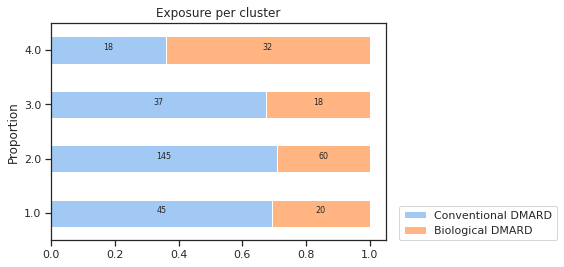

In [103]:
drug_name = 'Biological'

# Count unique physicians per cluster
df_drug_agg = df_relevant.groupby(['Cluster'])[drug_name].value_counts(normalize=True).unstack().fillna(0)

# Also create one with raw quantities
df_drug_quant = df_relevant.groupby(['Cluster'])[drug_name].value_counts(normalize=False).unstack().fillna(0)  

# Create Palette
rainbow = cm.get_cmap('hsv', 80)
newcolors = rainbow(np.linspace(0, 1, 80))
newcmp = ListedColormap(newcolors)

# Very simple one-liner using our agg_tips DataFrame.
df_drug_agg.plot(
kind = 'barh',
stacked = True,
title = 'Exposure per cluster',
mark_right = True,
xlabel = 'Proportion',
ylabel = 'Cluster') 

# Just add a title and rotate the x-axis labels to be horizontal.
plt.xticks(rotation=0, ha='center')
#plt.legend(['Conventional DMARD','Biological'], loc=(1.04,0), ncol= 3)

for n in df_drug_agg:
    for i, (cs, pc) in enumerate(zip(df_drug_agg.iloc[:, 0:].cumsum(1)[n],df_drug_agg[n])):
        (cs2, q) = list(zip(df_drug_quant.iloc[:, 0:].cumsum(1)[n],df_drug_quant[n]))[i]
        if np.round(pc * 100, 1) > 5: # Threshold = 5%
            plt.text(cs - pc / 2, i,  str(q),
                ha = 'center', rotation = 0, fontsize = 8)
plt.legend(['Conventional DMARD','Biological DMARD'],loc=(1.04,0), ncol= 1)
#print(df_patientBased.groupby(['PhenoGraph_clusters'])[drug_name].value_counts(normalize=False))    

#df_patientBased.groupby(['PhenoGraph_clusters'])[drug_name].value_counts(normalize=False).to_csv('../new_data/6_medication/Summary_Drug_Exposure.csv')

In [104]:
l_biological = ['ETA', 'ADA', 'INF', 'CERTO', 'GOL', 'ABA', 'TCZ', 'RTX', 'BARI', 'TOFA', 'GOUD']
if 0 in df_relevant['Cluster'].unique():
    df_relevant['Cluster'] += 1
l_csDMARD_succes = [len(df_relevant[((df_relevant['Cluster']==i) & (~df_relevant['FinalDrug'].str.contains('|'.join(l_biological), regex=True))  & (df_relevant['FinalTime']>364))]) for i in range(1,5)]
# Failure if most effective drug is a biological or if it is taken less than a year 
l_csDMARD_failure = [len(df_relevant[((df_relevant['Cluster']==i) & ((df_relevant['FinalDrug'].str.contains('|'.join(l_biological), regex=True)) | (df_relevant['FinalTime']<365)))]) for i in range(1,5)]
l_biological_succes = [len(df_relevant[((df_relevant['Cluster']==i) & (df_relevant['Biological']=='1')  & (df_relevant['FinalDrug'].str.contains('|'.join(l_biological), regex=True)) & (df_relevant['FinalTime']>364))]) for i in range(1,5)]
l_biological_failure = [len(df_relevant[((df_relevant['Cluster']==i) & (df_relevant['Biological']=='1') & ((~df_relevant['FinalDrug'].str.contains('|'.join(l_biological), regex=True)) | (df_relevant['FinalTime']<365)))]) for i in range(1,5)]


l_csDMARD_total = list(np.array(l_csDMARD_failure) + np.array(l_csDMARD_succes))
l_biological_total = list(np.array(l_biological_failure) + np.array(l_biological_succes))

df_results = pd.DataFrame( dict(
    csDMARD_Succes=np.array(l_csDMARD_succes), # success conventional
    csDMARD_Failure=np.array(l_csDMARD_failure) , # total convential
    Biological_Succes=np.array(l_biological_succes), # success biological
    Biological_Failure=np.array(l_biological_failure))) # total biological
df_results.index =[1,2,3,4]
df_results

,csDMARD_Succes,csDMARD_Failure,Biological_Succes,Biological_Failure
1,16,49,3,17
2,61,144,7,53
3,21,34,2,16
4,10,40,7,25


3
1
2
3
Cluster  Biological
1.0      0              45
         1              20
2.0      0             145
         1              60
3.0      0              37
         1              18
4.0      1              32
         0              18
Name: Biological, dtype: int64


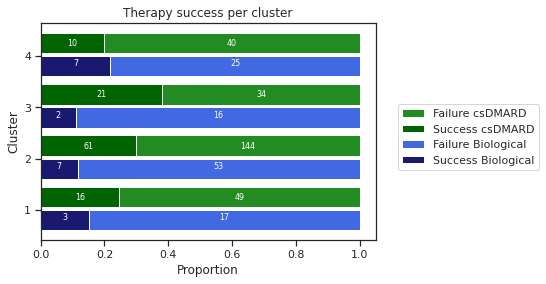

In [105]:
# Define Data
# Raw quantities
df_raw = pd.DataFrame(dict(
    x1=np.array(l_csDMARD_succes), # success conventional
    x2=np.array(l_csDMARD_failure), # total convential
    x3=np.array(l_biological_succes), # success biological
    x4=np.array(l_biological_failure))) # total biological
df = pd.DataFrame(dict(
    x1=np.array(l_csDMARD_succes) /np.array(l_csDMARD_total), # success conventional
    x2=[1,1,1,1] , # total convential
    x3=np.array(l_biological_succes)/np.array(l_biological_total), # success biological
    x4=[1,1,1,1])) # total biological

plt.barh([1+0.05, 2+0.05, 3+0.05, 4+0.05], df.x2, align='edge', height=0.40, color='forestgreen')
plt.barh([1+0.05, 2+0.05, 3+0.05, 4+0.05], df.x1, align='edge', height=0.40, color='darkgreen' )
plt.barh([1, 2, 3, 4], df.x4, align='edge', height=- 0.40,color='royalblue')
plt.barh([1, 2, 3, 4], df.x3, align='edge', height=- 0.40,  color='midnightblue')

plt.title('Therapy success per cluster')
plt.ylabel("Cluster")
plt.xlabel("Proportion")
plt.legend([ "Failure csDMARD",  "Success csDMARD", "Failure Biological","Success Biological"], bbox_to_anchor=(1.05, 0.65))

# Add text
for j, (q1, pc1) in enumerate(zip(df.iloc[:, 0:]['x1'],df['x1'])):
    print(i)
    i = j + 1
    raw_q1, raw_pc1 = list(zip(df_raw.iloc[:, 0:]['x1'],df_raw['x1']))[j]
    
    # also get bDMARD info
    (q2, pc2 ) = list(zip(df.iloc[:, 0:]['x3'],df['x3']))[j]
    raw_q2, raw_pc2 = list(zip(df_raw.iloc[:, 0:]['x3'],df_raw['x3']))[j]
    
    # also get failure info
    fail_q1, _ = list(zip(df_raw.iloc[:, 0:]['x2'],df_raw['x2']))[j]
    fail_q2, _ = list(zip(df_raw.iloc[:, 0:]['x4'],df_raw['x4']))[j]
    
    
    # conventional DMARD
    if np.round(pc1 * 100, 1) > 5: # Threshold = 5%
        plt.text(q1 - pc1 / 2, i+ 0.2,  str(raw_q1),
            ha = 'center', rotation = 0, fontsize = 8, color='white')
    if np.round(pc1 * 100, 1) > 5: # Failure
        plt.text(q1 + (fail_q1/(fail_q1+raw_q1)) /2, i+ 0.2,  str(fail_q1),
            ha = 'center', rotation = 0, fontsize = 8, color='white')
    
    # Biological DMARD
    if np.round(pc2 * 100, 1) > 5: # Threshold = 5%
        plt.text(q2 - pc2 / 2, i- 0.2,  str(raw_q2),
            ha = 'center', rotation = 0, fontsize = 8, color='white')
    if np.round(pc2 * 100, 1) > 5: # Failure
        plt.text(q2 + (fail_q2/(fail_q2+raw_q2)) /2, i- 0.2,  str(fail_q2),
            ha = 'center', rotation = 0, fontsize = 8, color='white')

plt.yticks(np.arange(1, 5, step=1))
#plt.legend(['Conventional DMARD','Biological DMARD'],loc=(1.04,0), ncol= 1)
print(df_relevant.groupby(['Cluster'])[drug_name].value_counts(normalize=False))   

,Succes,Failure
1,2,5
2,0,16
3,1,4
4,1,10


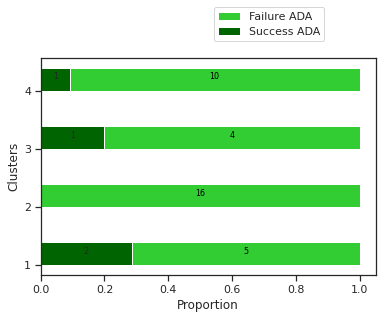

In [106]:
drug = 'ADA'

l_drug_succes = [len(df_relevant[((df_relevant['Cluster']==i) & (df_relevant['Exposed_to_%s' % (drug)]=='1')  & (df_relevant['FinalDrug'].str.contains(drug)) & (df_relevant['FinalTime']>364))]) for i in range(1,5)]
l_drug_failure = [len(df_relevant[((df_relevant['Cluster']==i) & (df_relevant['Exposed_to_%s' % (drug)]=='1') & ((~df_relevant['FinalDrug'].str.contains(drug)) | (df_relevant['FinalTime']<365)))]) for i in range(1,5)]

l_drug_total = list(np.array(l_drug_failure) + np.array(l_drug_succes))

df_drug_results = pd.DataFrame( dict(
    Succes=np.array(l_drug_succes), # success conventional
    Failure=np.array(l_drug_failure) )) # total convential
df_drug_results.index =[1,2,3,4]

# Define Data

df = pd.DataFrame(dict(
    x1=np.array(l_drug_succes) /np.array(l_drug_total), # success conventional
    x2=[1,1,1,1] )) # total biological

plt.barh( ['1', '2', '3', '4'], df.x2, align='edge', height=0.4, color='limegreen')
plt.barh(['1', '2', '3', '4'], df.x1, align='edge', height=0.4, color='darkgreen' )

#plt.yticks(['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.ylabel("Clusters")
plt.xlabel("Proportion")
plt.legend([ "Failure %s" % (drug),  "Success %s" % (drug)], bbox_to_anchor=(0.5, 1.05))


for i, (cs, pc) in enumerate(zip(df.iloc[:, 0:].cumsum(1)['x1'],df['x1'])):
    raw_q1, raw_pc1 = list(zip(df_drug_results.iloc[:, 0:]['Succes'],df_drug_results['Succes']))[i]
    raw_q2, raw_pc2 = list(zip(df_drug_results.iloc[:, 0:]['Failure'],df_drug_results['Failure']))[i]
    if np.round(pc * 100, 1) > 5: # Threshold = 5%
        plt.text(cs - pc / 2, i+ 0.2, str(raw_q1),
            ha = 'center', rotation = 0, fontsize = 8)
    if np.round((1-pc) * 100, 1) > 5: # Failure
        plt.text(pc + (raw_q2/(raw_q1+raw_q2)) /2, i+ 0.2,  str(raw_q2),
            ha = 'center', rotation = 0, fontsize = 8, color='black')

df_drug_results

## 5.4 Perform survival analysis for MTX-failure

In [ ]:
df_meta = pd.read_csv('../extractions/20240205_Clustering/metadata_rzwn.csv', sep='|')
df_old = pd.read_csv('../extractions/20240205_Clustering/patient_selection_rzwn.csv', sep='|') #
#df_meta['aCCP']

df_all = pd.merge(df_old[['PATNR', 'aCCP']],df_meta[['PATNR', 'aCCP']],  left_on='PATNR', right_on='PATNR')
df_all.drop_duplicates(subset=['PATNR'])

In [4]:
import pandas as pd

df_response = pd.read_csv('../proc/SummaryResponseTable_RZWN2.csv', sep=';') # SummaryResponseTable_maui_4 SummaryResponseTable2= MOFA,
df_response['Cluster'] = df_response['Cluster'] + 1

# create dummy variables
just_dummies = pd.get_dummies(df_response['Cluster'])

df_response = pd.concat([df_response, just_dummies], axis=1)   
df_response = df_response.rename(columns={1: 'Cluster1', 2: 'Cluster2', 3: 'Cluster3', 4: 'Cluster4', 5: 'Cluster5', 6: 'Cluster6'})

# Add metadata 
df_meta = pd.read_csv('../extractions/20240205_Clustering/metadata_rzwn.csv', sep='|')
df_response = pd.merge(df_response,df_meta,  left_on='patnr', right_on='PATNR')
#df_response

In [ ]:
import numpy as np

def getFollowUp(row, max_followup=None):
    if row['firstDateSwitch'] == row['firstDateSwitch']:
        if max_followup!= None :
            if row['firstDateSwitch'] > max_followup :
                return max_followup
            else :
                return row['firstDateSwitch']
        else :
            return row['firstDateSwitch']
    else :
        if max_followup!= None :
            if row['totalFollowUp'] > max_followup :
                return max_followup
            else :
                return row['totalFollowUp']
        else :
            return row['totalFollowUp'] #FollowUp
    
def setStatus(row, max_followup=None):
    if row['firstDateSwitch'] == row['firstDateSwitch']:
        if max_followup!= None :
            if row['firstDateSwitch'] > max_followup:
                return False
            else :
                return True
        else :
            return True
    else :
        return False


df_response['time'] = df_response.apply(lambda x: getFollowUp(x, max_followup=None), axis=1)
df_response['event'] = df_response.apply(lambda x: setStatus(x, max_followup=3150), axis=1) # total follow up RZWN 
df_response['event_1y'] = df_response.apply(lambda x: setStatus(x, max_followup=365), axis=1)
df_response['event_2y'] = df_response.apply(lambda x: setStatus(x, max_followup=365+365), axis=1)
df_response['succes_1y'] = df_response.apply(lambda x: abs(int(setStatus(x, max_followup=365))-1), axis=1)
df_response['event_8y'] = df_response.apply(lambda x: setStatus(x, max_followup=3150), axis=1)

# Save response table with outcome 
df_response.to_csv('../proc/SummaryResponseTable_RZWN_wOutcome.csv')
df_response

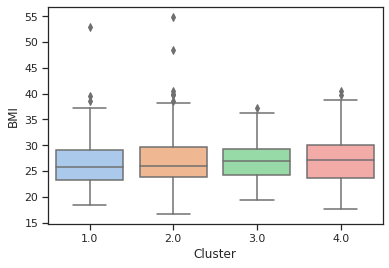

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", palette="pastel")

# Draw a nested boxplot to show bills by day and time
first_ax = sns.boxplot(x="Cluster", y="BMI",
            data=df_response)

ax = plt.gca()
plt.draw()

In [ ]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
ax = plt.subplot(111)
pal_colorblind =  [ '#4F6CCF', '#FBC93D']#
df_group = df_response[df_response['MTX-starter']==True].copy() # Subset on MTX-starters
df_group = df_group[df_group['totalFollowUp']>365].copy()
# , 'ACPA'
FOLLOWUP= 365  # *2

kmf = KaplanMeierFitter() # , timeline=range(1, FOLLOWUP, 1)

fig = plt.gcf()
fig.set_size_inches(8.5, 8.5)
ix = 0

# Set y-axis limits
plt.ylim(0, 1)  # Adjust the values as needed

for name, grouped_df in df_group.groupby(['aCCP']): #[df_response['aCCP']==1]
    kmf.fit(grouped_df["time"], grouped_df["event_1y"], label=name, timeline=range(0, FOLLOWUP, 1)) # , timeline=range(0, 365+62, 1)
    kmf.plot_survival_function(ax=ax,color=pal_colorblind[ix])
    print(grouped_df["time"].max())

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Treatment switch probability (%)')
    #ax.legend([])

    df = kmf.event_table.copy()
    df = df.reset_index()
    
    # calculate final patients that stay with baseline by hand (positive control)
    print('Patients that stay with treatment in cluster %s: %.3f' % (name,kmf.survival_function_.iloc[-1].values[0]), round(kmf.survival_function_.iloc[-1].values[0]*len(df_response[((df_response['time']>=0) & (df_response['Cluster']==name) )]))) # (df_response['time']>=0) &
    ix+=1

In [192]:
cph.fit(df_response[((df_response['MTX-starter']==1) & (df_response['totalFollowUp']>365) )][['time', EVENT, 'aCCP']], duration_col='time', event_col=EVENT, timeline=range(0, FOLLOWUP, 1))
p_val = cph.summary['p'].values[0]
effect = cph.summary['exp(coef)'].values[0]
ci_lower = cph.summary['exp(coef) lower 95%'].values[0]
ci_upper = cph.summary['exp(coef) upper 95%'].values[0]

p_val = p_val #/ len(list(itertools.combinations(range(1,7), 2))) # Conservative Bonferroni Multiple testing correction
print('Clusters %s-%s : HR:%s (%s-%s) p-val=%s ' % (x[0], x[1], round(effect,2), round(ci_lower,2), round(ci_upper,2), round(p_val,10)))


Clusters 3-4 : HR:0.72 (0.52-0.98) p-val=0.0399655035 


In [4]:
from lifelines import CoxPHFitter

import itertools

FOLLOWUP = 365
EVENT = 'event_1y'
N_CLUSTERS = 4
print('Follow up :', FOLLOWUP)
print('Alpha (after Bonferroni):', round(0.05/len(list(itertools.combinations(range(1,N_CLUSTERS+1), 2))), 5 ))

i = 1
for x in itertools.combinations(range(1,N_CLUSTERS+1), 2) :
    l_cluster = [x[0], x[1]] 
    if x[1] == 3:
        l_cluster = [3, x[0]]

    cph = CoxPHFitter()
    cph.fit(df_response[((df_response['MTX-starter']==1) & (df_response['totalFollowUp']>365)& (df_response['Cluster'].isin(l_cluster)) & (df_response['aCCP']==1))][['time', EVENT, 'Cluster%s' % (l_cluster[0])]], duration_col='time', event_col=EVENT, timeline=range(0, FOLLOWUP, 1))
    print(len(df_response[((df_response['MTX-starter']==1) & (df_response['totalFollowUp']>365) & (df_response['Cluster']==l_cluster[0]) & (df_response['aCCP']==0))]), len(df_response[((df_response['MTX-starter']==True) & (df_response['totalFollowUp']>365) & (df_response['Cluster'] == l_cluster[1]) & (df_response['aCCP']==1))]))
    p_val = cph.summary['p'].values[0]
    effect = cph.summary['exp(coef)'].values[0]
    ci_lower = cph.summary['exp(coef) lower 95%'].values[0]
    ci_upper = cph.summary['exp(coef) upper 95%'].values[0]
    
    p_val = p_val #/ len(list(itertools.combinations(range(1,7), 2))) # Conservative Bonferroni Multiple testing correction
    print('Clusters %s-%s : HR:%s (%s-%s) p-val=%s ' % (x[0], x[1], round(effect,2), round(ci_lower,2), round(ci_upper,2), round(p_val,10)))
    i = i + 1 

Follow up : 365
Alpha (after Bonferroni): 0.00833
26 121
Clusters 1-2 : HR:1.77 (1.18-2.67) p-val=0.0062165152 
29 41
Clusters 1-3 : HR:0.6 (0.34-1.06) p-val=0.0774539695 
26 27
Clusters 1-4 : HR:0.65 (0.4-1.05) p-val=0.0772938151 
29 121
Clusters 2-3 : HR:1.07 (0.65-1.78) p-val=0.7884645748 
95 27
Clusters 2-4 : HR:0.36 (0.24-0.55) p-val=2.0104e-06 
29 27
Clusters 3-4 : HR:0.38 (0.22-0.68) p-val=0.0009976041 


In [119]:
from lifelines import CoxPHFitter

import itertools

FOLLOWUP = 365
EVENT = 'event_1y'
N_CLUSTERS = 4
print('Follow up :', FOLLOWUP)
print('Alpha (after Bonferroni):', round(0.05/len(list(itertools.combinations(range(1,N_CLUSTERS+1), 2))), 5 ))

i = 1
for x in itertools.combinations(range(1,N_CLUSTERS+1), 2) :
    l_cluster = [x[0], x[1]] 
    if x[1] == 3:
        l_cluster = [3, x[0]]

    cph = CoxPHFitter()
    cph.fit(df_response[((df_response['MTX-starter']==1) & (df_response['totalFollowUp']>365)& (df_response['Cluster'].isin(l_cluster)) & (df_response['aCCP']==1))][['time', EVENT, 'Cluster%s' % (l_cluster[0])]], duration_col='time', event_col=EVENT, timeline=range(0, FOLLOWUP, 1))
    print(len(df_response[((df_response['MTX-starter']==1) & (df_response['totalFollowUp']>365) & (df_response['Cluster']==l_cluster[0]) & (df_response['aCCP']==0))]), len(df_response[((df_response['MTX-starter']==True) & (df_response['totalFollowUp']>365) & (df_response['Cluster'] == l_cluster[1]) & (df_response['aCCP']==1))]))
    p_val = cph.summary['p'].values[0]
    effect = cph.summary['exp(coef)'].values[0]
    ci_lower = cph.summary['exp(coef) lower 95%'].values[0]
    ci_upper = cph.summary['exp(coef) upper 95%'].values[0]
    
    p_val = p_val #/ len(list(itertools.combinations(range(1,7), 2))) # Conservative Bonferroni Multiple testing correction
    print('Clusters %s-%s : HR:%s (%s-%s) p-val=%s ' % (x[0], x[1], round(effect,2), round(ci_lower,2), round(ci_upper,2), round(p_val,10)))
    i = i + 1 

Follow up : 365
Alpha (after Bonferroni): 0.00833
26 117
Clusters 1-2 : HR:2.02 (1.15-3.57) p-val=0.0151736175 
30 41
Clusters 1-3 : HR:0.42 (0.17-1.05) p-val=0.0631007266 
26 27
Clusters 1-4 : HR:0.74 (0.38-1.47) p-val=0.3941903438 
30 117
Clusters 2-3 : HR:0.82 (0.34-1.97) p-val=0.6649077379 
95 27
Clusters 2-4 : HR:0.36 (0.19-0.66) p-val=0.0010317078 
30 27
Clusters 3-4 : HR:0.3 (0.12-0.78) p-val=0.0134905138 


## Just focus on C1 vs C3 aCCP+

Patients that stay with treatment in cluster (1.0, 0.0): 0.500 0
No of patients: 26
Patients that stay with treatment in cluster (1.0, 1.0): 0.488 0
No of patients: 41
Patients that stay with treatment in cluster (2.0, 0.0): 0.632 0
No of patients: 95
Patients that stay with treatment in cluster (2.0, 1.0): 0.711 0
No of patients: 121
Patients that stay with treatment in cluster (3.0, 0.0): 0.552 0
No of patients: 29
Patients that stay with treatment in cluster (3.0, 1.0): 0.760 0
No of patients: 25
Patients that stay with treatment in cluster (4.0, 0.0): 0.217 0
No of patients: 23
Patients that stay with treatment in cluster (4.0, 1.0): 0.481 0
No of patients: 27


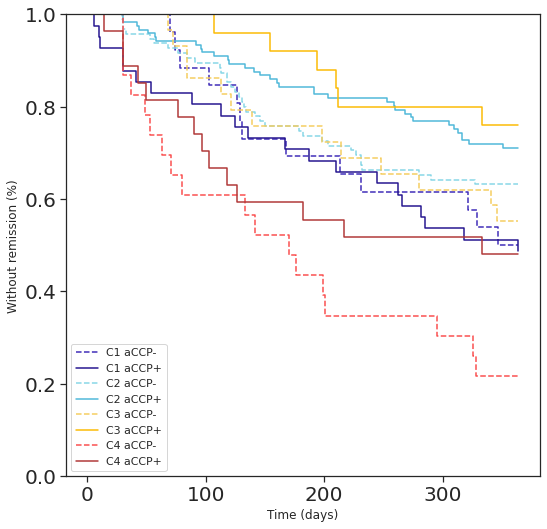

In [180]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import matplotlib 
import seaborn as sns
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
ax = plt.subplot(111)


FOLLOWUP= 365 

kmf = KaplanMeierFitter() # , timeline=range(1, FOLLOWUP, 1)

fig = plt.gcf()
fig.set_size_inches(8.5, 8.5)

# Set y-axis limits
plt.ylim(0, 1)  # Adjust the values as needed

df_group = df_response[df_response['MTX-starter']==True].copy() # Subset on MTX-starters
df_group = df_group[df_group['totalFollowUp']>365].copy()
#df_group = df_group[((df_group['Cluster'].isin([1, 3])) & (df_group['ACPA']==1))] # 


#palette = list(sns.color_palette("Paired").as_hex())
l_pal = ['#3d2ab8', '#24148f', '#87d6e6', '#4eb8d9',  '#f5cd5f', '#fcba03', '#FA4D4D', '#b03737',] # ['#77b4d4', '#1f78b4', '#f7aa45', '#ff7f00', '#79bd3c',  '#33a02c', '#f07271', '#e31a1c']

l_acpa_neg_c3 = []

i = 0
for name, grouped_df in df_group.groupby(['Cluster', 'aCCP']):
    kmf.fit(grouped_df["time"], grouped_df["event_1y"], label=name, timeline=range(0, FOLLOWUP, 1)) # , timeline=range(0, 365+62, 1)
    
    if i % 2 == 0:
        linestyle='dashed' 
    else :
        linestyle='solid'
    
    kmf.plot_survival_function(ax=ax, color = l_pal[i], ci_show=False, linestyle=linestyle) # 
    #print(grouped_df["time_till_Rem"].max())
   

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Without remission (%)')

    df = kmf.event_table.copy()
    df = df.reset_index()
    #print('balblble', str(name[0]), str(kmf.survival_function_.iloc[-1].values[0]))
    
    if name[0] == 3 and name[1] == 0 : 
        l_acpa_neg_c3 = list(grouped_df[grouped_df["time"]>0]['patnr'])
    # calculate final patients that stay with baseline by hand (positive control)
    print('Patients that stay with treatment in cluster %s: %.3f' % (name,kmf.survival_function_.iloc[-1].values[0]), round(kmf.survival_function_.iloc[-1].values[0]*len(df_response[((df_response['time']>=0) & (df_response['Cluster']==name) )]))) # (df_response['time']>=0) &
    print('No of patients:', len(grouped_df[grouped_df["time"]>0]))
    i += 1
    
# call method plt.legend
plt.legend(['C1 aCCP-', 'C1 aCCP+', 'C2 aCCP-', 'C2 aCCP+', 'C3 aCCP-', 'C3 aCCP+', 'C4 aCCP-', 'C4 aCCP+'])

## Conduct SHAP analysis

In [50]:
l_num = ['PATNR', 'Leuko', 'Hb', 'Trom',  'BSE', 'Age'] 

l_cat_shared = list(pd.read_csv('../extractions/20240205_Clustering/rzwn_columns_cat.csv', sep='|')['Columns'].values)
l_cat_patnr =  l_cat_shared[:-1] # remove age early and age late
l_cat_patnr.append('PATNR')

# Variables from replication set
df_categoric_replication = pd.read_csv('../extractions/20240205_Clustering/df_rzwn_categoric_ohe.csv', sep='|')[l_cat_patnr]
df_numeric_replication = pd.read_csv('../extractions/20240205_Clustering/df_rzwn_numeric_wide_scaled.csv', sep='|')[l_num]

# Select complete patients
df_meta = pd.read_csv('../extractions/20240205_Clustering/metadata_rzwn.csv', sep='|')

df_categoric_replication = df_categoric_replication.fillna(0)
df_numeric_replication = df_numeric_replication.fillna(0)

# Add cluster information
d_pt_cluster = dict(zip(df_replication['PATNR'], df_replication['PhenoGraph_clusters']))

# Original clustering information (same samples as development set)
df_cluster = df_man[df_man['Replication']==1].copy()
df_cluster['PhenoGraph_clusters'] = df_cluster['pseudoId'].apply(lambda x : d_pt_cluster[x])
df_cluster = df_cluster[['pseudoId', 'PhenoGraph_clusters']].copy()

df_profile = df_categoric_replication.merge(df_cluster, left_index=True, right_index=True)

# Add numerical data
df_profile = df_profile.merge(df_numeric_replication[[ 'Leuko', 'BSE', 'Hb', # 'MCV',
       'Trom', 'Age']], left_index=True, right_index=True)

In [51]:
import shap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import xgboost as xgb
import matplotlib.pyplot as plt
import time
import seaborn as sn
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

# Preload function
def strip_right(df, suffix='_positive'):
    df.columns = df.columns.str.replace(suffix+'$', '', regex=True)
strip_right(df_profile)

# 1. Create training & test set
cols_interest = [col for col in df_profile.columns if col not in ['pseudoId', 'PATNR', 'pseudoId2', 'Proba_cluster1', 'Proba_cluster2', 'Proba_cluster3',
       'Proba_cluster4']]
cols_interest = [col for col in cols_interest if 'negative' not in col]


df_train, df_test = train_test_split(df_profile[cols_interest], test_size=0.2, stratify=df_profile[target], random_state=28072022)

# 2. Fitting the model
cols_data = [x for x in list(cols_interest) if x not in [target]] 

X = df_train[cols_data].values
y = df_train[target] 


In [ ]:
import numpy as np

np.random.seed(1234)
# Apply 5 fold CV
kf = KFold(n_splits=3) # 
iteration = 0
y_pred = []

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index[:10], "TEST:", test_index[:10])
    X_train, X_test = pd.DataFrame(X).loc[train_index], pd.DataFrame(X).loc[test_index]
    y_train, y_test = np.take(y, np.array(train_index)), np.take(y, np.array(test_index))

    # Normalize
    fit_gaussian = False

    # Z-score scaling
    scaler = StandardScaler().fit(X_train)
    X_train= scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Model is an XGBClassifier
    n_trees = 100
    dmat_train = xgb.DMatrix(X_train, y_train)
    dmat_test = xgb.DMatrix(X_test, y_test)

    t0 = time.time()
    bst  = xgb.train({'objective': 'multi:softmax', 'num_class':len(y.unique())}, dmat_train,
                        n_trees, evals=[(dmat_train, "train"), (dmat_test, "test")]) # "tree_method": "gpu_hist", 
    t1 = time.time()
    print('Time for Training XGB model %s: %s' % (str(iteration+1), str(t1-t0)))
    iteration += 1
    
    # Create a confusion matrix over all data!
    y_pred.extend(bst.predict(dmat_test))


Text(0.5, 1.0, 'Confusion matrix for the XGBoost classifier - both categorical + numerical (ACC: 0.76)')

<Figure size 432x288 with 0 Axes>

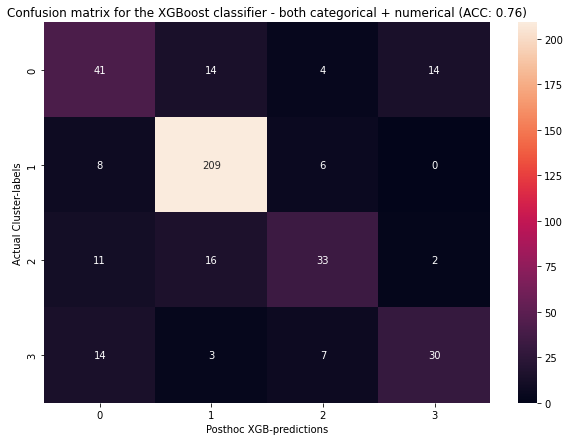

In [53]:
# PLot
fig = plt.figure()
cm = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)


df_cm = pd.DataFrame(cm, index = list(range(len(y.unique()))),
                  columns = list(range(len(y.unique()))))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel("Posthoc XGB-predictions")
plt.ylabel("Actual Cluster-labels")
plt.title('Confusion matrix for the XGBoost classifier - both categorical + numerical (ACC: %.2f)' % (accuracy))

In [54]:
N_FEAT = 15
t0 = time.time()
#shap_values = bst.predict(dmat_test, pred_contribs=True)
t_explainer = shap.TreeExplainer(bst) # or just X?
shap_values = t_explainer.shap_values(X_test)
t1 = time.time()
print('Calculating SHAP: ' + str(t1-t0))

Calculating SHAP: 0.2965736389160156


In [55]:
import sys
sys.path.append(r'../../src/1_emr_scripts')
import MannequinFunctions as func

df_shapley = pd.DataFrame(data=X_test, columns = cols_data)

plt.figure(figsize = (5,8))
# Plot each class
for class_idx in range(len(y.unique())):
    
    # Get top 15 of original set
    df_old_importances = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/figures/4_downstream/SHAP_RANKED_raw_class%s.csv' % (str(class_idx)), sep='|')
    old_feature_names = df_old_importances['col_name'].values[:N_FEAT]
    #old_feature_names = [rename_mannequin_features(feat) for feat in old_feature_names] # translate
    
    
    # Get top 15 of current set
    vals= np.abs([shap_values[class_idx]]).mean(0) # .mean(0)
    feature_importance = pd.DataFrame(list(zip(cols_data,sum(vals), np.abs([shap_values[class_idx]]).mean(0))),columns=['col_name','feature_importance_vals', 'feature_importance_vals_raw'])
    feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
    feature_names = feature_importance['col_name'].values[:N_FEAT]

    # Add position 
    labels = [func.rename_mannequin_features(feat) for feat in feature_names]
    labels = ['%s %s' % (i, labels[i]) for i in range(14,-1,-1)]
    
    # sort feature names according to original set
    #sorted_labels = ['' * range(len(labels))]
    
    import numpy
    empty_str = ' '*100
    S=numpy.array([empty_str] * len(labels))
    
    
    overlap = set(old_feature_names).intersection(feature_names)
    non_overlap = list([ i for i in feature_names if i not in old_feature_names])
    print(non_overlap)
    #print('Non-overlap: ', non_overlap)
    #print(feature_names)
    
    l_nr =numpy.array([0] * len(labels))
    l_color = numpy.array(['......'] * len(labels))
    l_weight = numpy.array(['normal'] * len(labels)) 
    
    for i in overlap:
        ix = list(old_feature_names).index(i)
        S[ix] = i
        l_nr[ix] = list(feature_names).index(i)
        l_color[ix] = 'teal' # color matches
        l_weight[ix] = 'bold'
    #l_color = [for col in l_color return col if col != '......'  else 'black']
    l_color = [col if col != '......' else 'black' for col in l_color]
    for ix, i in enumerate(S):
        if i == empty_str:
            S[ix] = non_overlap[0] 
            #print(non_overlap[-1])
            l_nr[ix] = list(feature_names).index(non_overlap[0])
            non_overlap.pop(0)   
    
        
    #print(S)
    print(l_nr)
    print(feature_names, S)
    #print(old_feature_names)
    #print(S)
    
    X_test_filt = df_shapley[S].values
    fig = shap.summary_plot(pd.DataFrame(data=shap_values[class_idx], columns = cols_data)[S].values, X_test_filt, feature_names=S, show=False,sort=False) 
    #plt.figure(figsize=(3, 3))
    
    fig, ax = plt.gcf(), plt.gca()
    #plt.figure(figsize=(2, 8)) # , dpi=80
    
    #print(ax.get_yticks())
    #ticks_loc = ax.get_yticks().tolist()
    ax.set_yticks(ax.get_yticks().tolist())
    ax.set_yticklabels(['%s %s' % (int(l_nr[::-1][ix])+1, func.rename_mannequin_features(i)) for ix, i in enumerate(S[::-1])], fontsize=23) 
    #ax.set_yticklabels(labels)
    
    for ix in range(len(labels)):
        plt.gca().get_yticklabels()[ix].set_color(l_color[::-1][ix])
        plt.gca().get_yticklabels()[ix].set_fontweight(l_weight[::-1][ix])

    
    #plt.show()
    
    plt.subplots_adjust(bottom=0.4)
    plt.tight_layout()
    plt.savefig('../figures/shap/shap%s_rzwn_new.png' % (str(class_idx)))
    plt.clf()

['Pijn_mtp 4 links', 'Pijn_schouder R', 'Pijn_schouder L', 'Pijn_mtp 2 rechts', 'Pijn_knie links', 'Zwelling_mcp 2 rechts', 'Zwelling_mcp 5 rechts', 'Pijn_mcp 5 links', 'Zwelling_mtp 4 rechts', 'Pijn_pols L', 'Zwelling_bovenste spronggewricht rechts', 'Zwelling_pols R', 'Pijn_pip 3 links hand']
[ 4  1  2  3  5  6  7  8  9 10 11 12  0 13 14]
['Pijn_mtp 3 rechts' 'Pijn_mtp 4 links' 'Pijn_schouder R'
 'Pijn_schouder L' 'Pijn_mtp 3 links' 'Pijn_mtp 2 rechts'
 'Pijn_knie links' 'Zwelling_mcp 2 rechts' 'Zwelling_mcp 5 rechts'
 'Pijn_mcp 5 links' 'Zwelling_mtp 4 rechts' 'Pijn_pols L'
 'Zwelling_bovenste spronggewricht rechts' 'Zwelling_pols R'
 'Pijn_pip 3 links hand'] ['Pijn_mtp 3 links' 'Pijn_mtp 4 links' 'Pijn_schouder R' 'Pijn_schouder L'
 'Pijn_mtp 2 rechts' 'Pijn_knie links' 'Zwelling_mcp 2 rechts'
 'Zwelling_mcp 5 rechts' 'Pijn_mcp 5 links' 'Zwelling_mtp 4 rechts'
 'Pijn_pols L' 'Zwelling_bovenste spronggewricht rechts'
 'Pijn_mtp 3 rechts' 'Zwelling_pols R' 'Pijn_pip 3 links hand']
['

<Figure size 576x540 with 0 Axes>

### Check DAS44 at baseline

In [4]:
import pandas as pd

df_response = pd.read_csv('../proc/SummaryResponseTable_RZWN_wOutcome.csv')
df_response['pseudoId'] = df_response['patnr'].copy()

In [5]:
import pandas as pd
l_DAS28 = ['Pijn_pols L', 'Pijn_pols R', 'Pijn_pip 2 links hand', 'Pijn_pip 2 rechts hand', 'Pijn_pip 3 links hand', 'Pijn_pip 3 rechts hand',
 'Pijn_pip 4 links hand', 'Pijn_pip 4 rechts hand', 'Pijn_pip 5 links hand', 'Pijn_pip 5 rechts hand', 
 'Pijn_mcp 1 links', 'Pijn_mcp 1 rechts', 'Pijn_mcp 2 links', 'Pijn_mcp 2 rechts', 'Pijn_mcp 3 links', 'Pijn_mcp 3 rechts',
 'Pijn_mcp 4 links', 'Pijn_mcp 4 rechts', 'Pijn_mcp 5 links', 'Pijn_mcp 5 rechts', 'Pijn_schouder L', 'Pijn_schouder R', 'Pijn_Elleboog L','Pijn_elleboog R',
 'Pijn_knie links', 'Pijn_knie rechts', 
           
 'Zwelling_pols L', 'Zwelling_pols R', 'Zwelling_pip 2 links hand',  'Zwelling_pip 2 rechts hand',
 'Zwelling_pip 3 links hand',  'Zwelling_pip 3 rechts hand', 'Zwelling_pip 4 links hand', 'Zwelling_pip 4 rechts hand',  'Zwelling_pip 5 links hand',
 'Zwelling_pip 5 rechts hand',  'Zwelling_mcp 1 links', 'Zwelling_mcp 1 rechts', 'Zwelling_mcp 2 links', 'Zwelling_mcp 2 rechts', 'Zwelling_mcp 3 links', 'Zwelling_mcp 3 rechts',
 'Zwelling_mcp 4 links', 'Zwelling_mcp 4 rechts', 'Zwelling_mcp 5 links', 'Zwelling_mcp 5 rechts', 
 'Zwelling_knie links', 'Zwelling_knie rechts', 'Zwelling_schouder L', 'Zwelling_schouder R', 'Zwelling_Elleboog L',
  'Zwelling_elleboog R',
               
                #'Pijn_IP links', 'Pijn_IP rechts',  'Zwelling_IP links', 'Zwelling_IP rechts',
                   ]
l_DAS44 = l_DAS28 + [ 'Zwelling_sternoclaviculair L', 'Zwelling_sternoclaviculair R', 'Pijn_sternoclaviculair L', 'Pijn_sternoclaviculair R',
               'Zwelling_acromioclaviaculair L', 'Zwelling_acromioclaviaculair R', 'Pijn_acromioclaviaculair L', 'Pijn_acromioclaviaculair R',
                    'Pijn_onderste spronggewricht links', 'Pijn_onderste spronggewricht rechts', 'Pijn_bovenste spronggewicht links', 'Pijn_bovenste spronggewricht rechts',
             'Zwelling_onderste spronggewricht links', 'Zwelling_onderste spronggewricht rechts', 'Zwelling_bovenste spronggewicht links', 'Zwelling_bovenste spronggewricht rechts',
                'Pijn_mtp 2 links', 'Pijn_mtp 2 rechts', 'Pijn_mtp 3 links', 'Pijn_mtp 3 rechts', 'Pijn_mtp 4 links', 'Pijn_mtp 4 rechts',
 'Pijn_mtp 5 links', 'Pijn_mtp 5 rechts','Zwelling_mtp 2 links', 'Zwelling_mtp 2 rechts', 'Zwelling_mtp 3 links', 'Zwelling_mtp 3 rechts', 'Zwelling_mtp 4 links', 'Zwelling_mtp 4 rechts',
 'Zwelling_mtp 5 links', 'Zwelling_mtp 5 rechts',
              ]
    
metadata_rep = pd.read_csv('../extractions/20240205_Clustering/metadata_rzwn.csv', sep='|')

d_tjc44= dict(zip(metadata_rep['PATNR'], metadata_rep[[col for col in l_DAS44 if 'Pijn' in col]].sum(axis=1)))
d_sjc44= dict(zip(metadata_rep['PATNR'], metadata_rep[[col for col in l_DAS44 if 'Zwelling' in col]].sum(axis=1)))

d_tjc28= dict(zip(metadata_rep['PATNR'], metadata_rep[[col for col in l_DAS28 if 'Pijn' in col]].sum(axis=1)))
d_sjc28= dict(zip(metadata_rep['PATNR'], metadata_rep[[col for col in l_DAS28 if 'Zwelling' in col]].sum(axis=1)))

In [6]:
import pandas as pd

import pandas as pd
# Load Mannequin
final_df = pd.read_csv('/exports/reum/tdmaarseveen/RA_Clustering/new_data/4_processed/DF_Mannequin_NEW_Engineered.csv', sep='|')

# Add MTP incidence (for quality check)
FEET_JOINTS = [col for col in metadata_rep.columns if ('pip' in col or 'mtp' in col or 'dip' in col or 'IP' in col)  and 'hand' not in col]
HAND_JOINTS = [col for col in metadata_rep.columns if ('tarso' in col or 'pip' in col or 'mcp' in col or 'cmc' in col or 'dip' in col or 'IP' in col  or 'pols' in col)  and 'voet' not in col]
ARM_JOINTS = [col for col in metadata_rep.columns if ('schouder' in col or 'elleboog' in col)]
LEG_JOINTS = [col for col in metadata_rep.columns if ('knie' in col or 'heup' in col or 'sprong' in col)]
UPPER_JOINTS = [col for col in metadata_rep.columns if ('Manubrio' in col or 'temporo' in col or 'schouder' in col or 'elleboog' in col) ]

metadata_rep['FEET-count'] = metadata_rep[FEET_JOINTS].sum(axis=1)
metadata_rep['HAND-count'] = metadata_rep[HAND_JOINTS].sum(axis=1)
metadata_rep['ARM-count'] = metadata_rep[ARM_JOINTS].sum(axis=1)
metadata_rep['LEG-count'] = metadata_rep[LEG_JOINTS].sum(axis=1)
metadata_rep['UPPER-count'] = metadata_rep[UPPER_JOINTS].sum(axis=1)

d_feet = dict(zip(metadata_rep['PATNR'],metadata_rep['FEET-count']))
d_hands = dict(zip(metadata_rep['PATNR'],metadata_rep['HAND-count']))

df_response['FEETcount'] = df_response['pseudoId'].apply(lambda x : d_feet[x])
df_response['HANDcount'] = df_response['pseudoId'].apply(lambda x : d_hands[x])
#df_response

In [12]:
import numpy as np

df_response = df_response[df_response['MTX-starter']==True]# 'Cluscat',

if 'Age' not in df_response.columns:
    df_response = df_response.merge(df_replication[['PATNR', 'Age', 'Sex', 'RF', 'aCCP', 'SJC', 'TJC', 'BSE', 'HANDcount', 'FEETcount']], left_on='patnr', right_on='PATNR')
df_response['pseudoId'] = df_response['patnr'].copy()

df_response['SJC28'] = df_response['patnr'].apply(lambda x : d_sjc28[x])
df_response['TJC28'] = df_response['patnr'].apply(lambda x : d_tjc28[x])

df_response['SJC44'] = df_response['patnr'].apply(lambda x : d_sjc28[x])
df_response['TJC44'] = df_response['patnr'].apply(lambda x : d_tjc28[x])

def calculate_DAS44(tjc, sjc, esr):
    """
    Calculate DAS44 with 3 variables : RAI, SJC and ESR (BSE)
    """

    das44= (0.53938 * np.sqrt(tjc) + 0.0650 * (sjc) + 0.330 * np.log(esr)) + 0.224 #0.224
    return das44

df_response['DAS44'] = df_response.apply(lambda x : calculate_DAS44(x['SJC44'], x['TJC44'], x['BSE']), axis=1)
#df_response['DAS44'] = df_response['pseudoId'].apply(lambda x : d_das44[x] if x in d_das44.keys() else np.nan) 

#  'symptomDuration', 'diseaseDuration', 'MannTillTreat', 

# Check for remission
# [(df_response['Cluster'].isin([3,4]))]
df_response[['pseudoId', 'time', 'event', 'event_1y', 'event_8y', 'Cluster',  'Cluster1', 'Cluster2', 'Cluster3', 'Cluster4', 'Age', 'Sex', 'SJC44', 'TJC44', 'aCCP', 'RF', 'BSE','MTX-starter', 'DAS44', 'HANDcount', 'FEETcount']].to_csv('../proc/df_survivaldata_RZWN.csv')


### Check within ACPA stratum for MTX 

#### C3-C1 difference

In [45]:
df_response[((df_response['Cluster'].isin([1,3])) & (df_response['aCCP']==1) & (df_response['totalFollowUp']>365) & (df_response['MTX-starter']==True))][['pseudoId', 'time', 'event', 'event_1y', 'event_8y', 'Cluster',  'Cluster1', 'Cluster2', 'Cluster3', 'Cluster4', 'Age', 'Sex', 'SJC', 'TJC', 'aCCP', 'RF','MTX-starter', 'DAS44']].to_csv('../proc/df_survivaldata_RZWN.csv')


#### C3-C4 difference

In [44]:
df_response[((df_response['Cluster'].isin([4,3])) & (df_response['totalFollowUp']>365) & (df_response['aCCP']==1) & (df_response['MTX-starter']==True) )][['pseudoId', 'time', 'event', 'event_1y', 'event_8y', 'Cluster',  'Cluster1', 'Cluster2', 'Cluster3', 'Cluster4', 'Age', 'Sex', 'SJC', 'TJC', 'aCCP', 'RF','MTX-starter', 'DAS44']].to_csv('../proc/df_survivaldata_RZWN.csv')


In [164]:
df_response[((df_response['totalFollowUp']>365) & (df_response['MTX-starter']==True) )][['pseudoId', 'time', 'event', 'event_1y', 'event_8y', 'Cluster',  'Cluster1', 'Cluster2', 'Cluster3', 'Cluster4', 'Age', 'Sex', 'SJC', 'TJC', 'ACPA', 'RF','MTX-starter']].to_csv('../proc/df_survivaldata_RZWN_2.csv')

In [17]:
#  'symptomDuration', 'diseaseDuration', 'MannTillTreat', 
df_response[['pseudoId', 'time', 'event', 'event_1y', 'event_8y', 'Cluster',  'Cluster1', 'Cluster2', 'Cluster3', 'Cluster4', 'Age', 'Sex', 'SJC', 'TJC', 'aCCP', 'RF', 'BSE', 'MTX-starter', 'DAS44']].to_csv('../proc/df_survivaldata_RZWN.csv')
#df_response[df_response['Cluster'].isin([3,4])][['pseudoId', 'time', 'event', 'event_1y', 'event_8y', 'Cluster',  'Cluster1', 'Cluster2', 'Cluster3', 'Cluster4', 'Age', 'Sex', 'SJC', 'TJC', 'aCCP', 'RF','MTX-starter', 'DAS44']].to_csv('../proc/df_survivaldata_RZWN.csv')